### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Example match
Data taken from https://www.oddsportal.com/basketball/usa/nba/houston-rockets-golden-state-warriors-lMlLpR7P/
This part is needed to itroduce reader that sports odds change over time prior to match start.

In [2]:
df_example = pd.read_csv("data/example_basketball_game.csv", index_col=0)
df_example['Time'] = pd.to_datetime(df_example['Time'])
df_example = df_example.rename(columns={"Type": "Team name"})
df_example.head()

,Time,Book_n,Coef,Team name
0,2018-11-16 01:39:00,10Bet,1.59,home
1,2018-11-15 20:06:00,10Bet,1.63,home
2,2018-11-15 19:15:00,10Bet,1.67,home
3,2018-11-15 18:06:00,10Bet,1.65,home
4,2018-11-15 16:03:00,10Bet,1.73,home


## 1.1 Plot coeficient temporal dependance

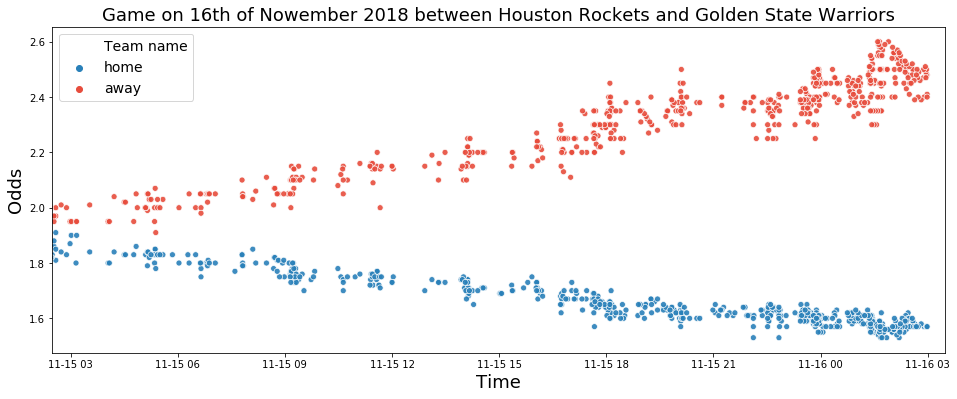

In [3]:
x_min = df_example.Time.max() - datetime.timedelta(hours=24.5)
x_max = df_example.Time.max() + datetime.timedelta(hours=0.5)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="Time", y="Coef", hue="Team name", data=df_example,
                     palette=dict(home="#2980b9", away="#e74c3c"), alpha=0.9)
ax.set_title("Game on 16th of Nowember 2018 between Houston Rockets and Golden State Warriors",
            fontsize=18)
ax.set_ylabel("Odds",fontsize=18)
ax.set_xlabel("Time", fontsize=18)
ax.set_xlim(x_min, x_max)
plt.legend(fontsize=14);
plt.savefig("images/example_game_time.png", dpi=200, format="png", bbox_inches="tight");

## 1.2 Plot histogram of last available coeficients 

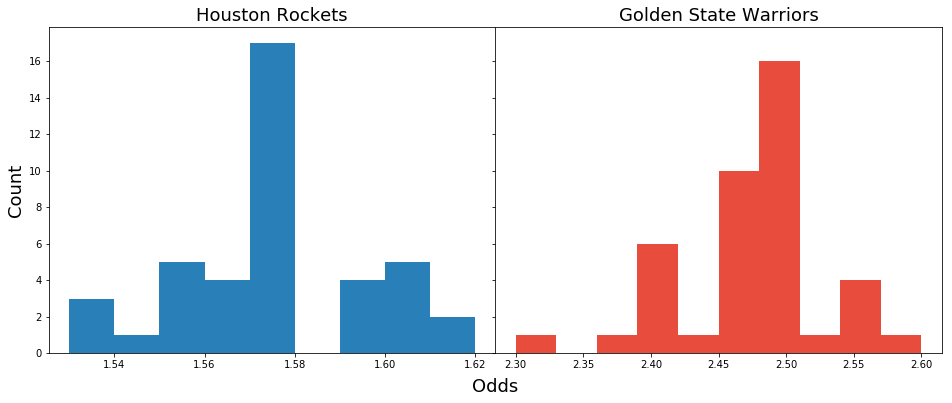

In [4]:
# process results
home_last = df_example[df_example["Team name"]=="home"].groupby('Book_n')["Coef"].first()
away_last = df_example[df_example["Team name"]=="away"].groupby('Book_n')["Coef"].first()
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.hist(home_last.values, bins=9, color="#2980b9")
ax1.set_ylabel("Count", fontsize=18)
ax1.set_title("Houston Rockets", fontsize=18)
ax2.hist(away_last.values, bins=10, color="#e74c3c")
ax2.set_title("Golden State Warriors", fontsize=18)
f.subplots_adjust(wspace=0)
ax2.set_xlabel("Odds", fontsize=18);
ax2.xaxis.set_label_coords(0, -0.075);
plt.savefig("images/example_game_last_coeff.png", dpi=200, format="png", bbox_inches="tight");

# 2. Data preparation
Due to complicated data scraping procedure (website was rendered in Javascript), data is located in many different .csv files. This section is used to clean and preparare data for further analysis.Main objectives:
* Load all data into DataFrames,
* Check for NAN values (drop NAN rows if needed),
* Check for duplicates,
* Concactinate everything into single DataFrame.

## 2.1 Game outcomes
File `basketball_games.csv` contains infomration about NBA and Euroleague games. Each column coresponds to:
* League name,
* Season match was played on,
* Away team final score,
* Home team final score,
* Who won (1.0- Home team won, 0.0- Away Team won),
* Did game require overtime (OT)? (1.0- Yes, 0.0- No),
* Highest avaibable coeficient for Home win prior to match start,
* Highest avaibable coeficient for Away win prior to match start,
* Link to detailed information about the match. URL link is unique for each match.

In [5]:
df_scores = pd.read_csv("data/basketball_games.csv", index_col=0)
df_scores.head()

,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,URL
0,NBA,2017/2018,85.0,108.0,0.0,0.0,2.55,1.68,https://www.oddsportal.com/basketball/usa/nba-...
1,NBA,2017/2018,102.0,110.0,0.0,0.0,2.35,1.75,https://www.oddsportal.com/basketball/usa/nba-...
2,NBA,2017/2018,122.0,103.0,1.0,0.0,1.23,5.80,https://www.oddsportal.com/basketball/usa/nba-...
3,NBA,2017/2018,124.0,114.0,1.0,1.0,1.14,8.16,https://www.oddsportal.com/basketball/usa/nba-...
4,NBA,2017/2018,92.0,101.0,0.0,0.0,3.50,1.40,https://www.oddsportal.com/basketball/usa/nba-...


In [6]:
# check for NAN values
df_scores.isna().sum()

League        0
Season        0
Home_score    1
Away_score    1
Win           1
OT            1
Home_p        0
Away_p        0
URL           0
dtype: int64

In [7]:
# Make sure there are no duplicate entries
print("original data has {} entries".format(df_scores.shape[0]))
df_scores = df_scores.drop_duplicates(subset='URL', keep="first")
print("after droping duplicates {} entries left".format(df_scores.shape[0]))
# Drop missing values
df_scores = df_scores.dropna()
print("after droping NAN values {} entries left".format(df_scores.shape[0]))

original data has 8345 entries
after droping duplicates 8345 entries left
after droping NAN values 8344 entries left


In [8]:
# Calculate total points cored per match
df_scores['Total'] = df_scores["Away_score"] + df_scores["Home_score"]
# Change data type from float to integer
df_scores["Win"] = df_scores["Win"].astype(int)
df_scores["OT"] = df_scores["OT"].astype(int)

In [9]:
# check how many entries per league per season there are
df_scores.groupby(["League", "Season"])["URL"].count()

League  Season   
EURO    2013/2014     260
        2014/2015     258
        2015/2016     250
        2016/2017     259
        2017/2018     260
NBA     2013/2014    1428
        2014/2015    1419
        2015/2016    1418
        2016/2017    1408
        2017/2018    1384
Name: URL, dtype: int64

### 2.2 Detailed market coefficient information
Files `NBA_201X_201Y.csv` and `EURO_201X_201Y.csv` contains detailed information about market prices. Each column coresponds to:
* Asian Handicap (AH), calculated to home team, e.g. +3.5 means that after match is over, 3.5 points are added to home team score and only then match winner is decided,
* Coefficient for AH bet on Home team,
* Coefficient for AH bet on Away team,
* Over/Under (OU) value. Bet is won if total score is above (over) or bellow (under) the OU value. If OU is whole number, e.g. 157, and total points scored is equal to OU, bet is voided (money is returned to betor),
* Over coefficient value,
* Under coefficient value,
* Home team name,
* Away team name,
* Date and hour match started,
* Link to detailed information about the match. URL link is unique for each match.

In [10]:
filenames = ["EURO_2014_2015.csv", "EURO_2015_2016.csv", "EURO_2016_2017.csv", "EURO_2017_2018.csv",
            "NBA_2013_2014.csv", "NBA_2014_2015.csv", "NBA_2015_2016.csv", "NBA_2016_2017.csv",
            "NBA_2017_2018.csv"]
df_detailed = pd.read_csv("data/EURO_2013_2014.csv", index_col=0)
for fname in filenames:
    df_detailed = pd.concat([df_detailed, pd.read_csv("data/"+fname, index_col=0)], ignore_index=True)

df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,Asian handicap -10.5,1.95,2.12,Over/Under +157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,"Sunday, 18 May 2014, 21:00",https://www.oddsportal.com/basketball/europe/e...
1,Asian handicap -2.5,1.98,2.02,Over/Under +151.5,2.05,1.95,Barcelona,CSKA Moscow,"Sunday, 18 May 2014, 18:00",https://www.oddsportal.com/basketball/europe/e...
2,Asian handicap +2.5,1.95,2.20,Over/Under +155.5,2.10,1.97,Barcelona,Real Madrid,"Friday, 16 May 2014, 22:00",https://www.oddsportal.com/basketball/europe/e...
3,Asian handicap -6.5,1.95,2.08,Over/Under +147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,"Friday, 16 May 2014, 19:00",https://www.oddsportal.com/basketball/europe/e...
4,Asian handicap -8.5,2.03,1.95,Over/Under +153.5,2.01,1.91,Real Madrid,Olympiakos,"Friday, 25 Apr 2014, 21:45",https://www.oddsportal.com/basketball/europe/e...


In [11]:
# check for dublicate entries
print("original data has {} entries".format(df_detailed.shape[0]))
df_detailed = df_detailed.drop_duplicates(subset='URL', keep="first")
print("after removing duplicates {} entries left".format(df_detailed.shape[0]))
# Drop missing values
df_detailed = df_detailed.dropna()
print("after removign NAN values {} entries left".format(df_detailed.shape[0]))

original data has 8345 entries
after removing duplicates 8345 entries left
after removign NAN values 8320 entries left


In [12]:
def convert_OU(s):
    """
    Input:
        s: string, e.g. "Over/Under +157.5"
    Output:
        float, 157.5
    """
    try:
        return float(s[12:-1])
    except:
        return np.nan
    
def convert_AH(s):
    """
    Input:
        s: string, e.g. "Over/Under +157.5"
    Output:
        float, 157.5
    """
    try:
        return float(s[15:-1])
    except:
        return np.nan

# convert Over/Under and Asian Handicaps bet types to floats
df_detailed["OU"] = df_detailed["OU"].astype("str").apply(convert_OU)
df_detailed["AH"] = df_detailed["AH"].astype("str").apply(convert_AH)
df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,"Sunday, 18 May 2014, 21:00",https://www.oddsportal.com/basketball/europe/e...
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,"Sunday, 18 May 2014, 18:00",https://www.oddsportal.com/basketball/europe/e...
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,"Friday, 16 May 2014, 22:00",https://www.oddsportal.com/basketball/europe/e...
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,"Friday, 16 May 2014, 19:00",https://www.oddsportal.com/basketball/europe/e...
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,"Friday, 25 Apr 2014, 21:45",https://www.oddsportal.com/basketball/europe/e...


In [13]:
# Convert Date to datetime element
df_detailed["Date"] = pd.to_datetime(df_detailed['Date'], format='%A, %d %b %Y, %H:%M')
df_detailed.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,https://www.oddsportal.com/basketball/europe/e...
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,2014-05-18 18:00:00,https://www.oddsportal.com/basketball/europe/e...
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,2014-05-16 22:00:00,https://www.oddsportal.com/basketball/europe/e...
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,https://www.oddsportal.com/basketball/europe/e...
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,2014-04-25 21:45:00,https://www.oddsportal.com/basketball/europe/e...


## 2.3 Combine everything into one DataFrame

In [14]:
df = pd.merge(df_detailed, df_scores, on='URL', how='inner')
# check how many entries per League season is left after cleaning data
df.groupby(["League", "Season"])["URL"].count()

League  Season   
EURO    2013/2014     258
        2014/2015     255
        2015/2016     250
        2016/2017     259
        2017/2018     257
NBA     2013/2014    1426
        2014/2015    1410
        2015/2016    1418
        2016/2017    1408
        2017/2018    1378
Name: URL, dtype: int64

In [15]:
# check how much data was lost due to data scraping and processing processing
print("Missing data entries per League per Season after data wrangling")
df_scores.groupby(["League", "Season"])["URL"].count() - df.groupby(["League", "Season"])["URL"].count()

Missing data entries per League per Season after data wrangling


League  Season   
EURO    2013/2014    2
        2014/2015    3
        2015/2016    0
        2016/2017    0
        2017/2018    3
NBA     2013/2014    2
        2014/2015    9
        2015/2016    0
        2016/2017    0
        2017/2018    6
Name: URL, dtype: int64

Information was not gathered only on 25 matches , i.e. only 0.3 % of all data was missing.

## 2.4 Create DataFrame for all posible bets

Each row of `df_scores` DataFrame contains information about 3 bets (6 posible outcomes), head to head (home or away team win), asian handicap (home or away team win) and totals (under or over X amount of points). 

In [16]:
%%time
_data = list()
for idx in df.index:
    # get head to head (H2H) bets
    
    # calculate total implied probability for home/away bet
    implied_prop = 1/df.iloc[idx]["Home_p"] + 1/df.iloc[idx]["Away_p"]
    
    if df.iloc[idx]["Home_score"] > df.iloc[idx]["Away_score"]:
        _data.append(["H2H", "Home", df.iloc[idx]["Home_p"],
                      df.iloc[idx]["Home_p"]-1, implied_prop, df.iloc[idx]["URL"], 1])
        _data.append(["H2H", "Away", df.iloc[idx]["Away_p"],
                      -1, implied_prop, df.iloc[idx]["URL"], 0])
    else:
        _data.append(["H2H", "Home", df.iloc[idx]["Home_p"],
                      -1, implied_prop, df.iloc[idx]["URL"], 0])
        _data.append(["H2H", "Away", df.iloc[idx]["Away_p"],
                      df.iloc[idx]["Away_p"]-1, implied_prop, df.iloc[idx]["URL"], 1])
    
    # get Asian handicap and Over/Under bets, but only from matches without overtime (OT)
    # diffrent bookmakers have diffrent rules for OT games. For this reason I just exclude all OT games
    if df.iloc[idx]["OT"] == 0:
        
        # get Asian Handicap bets
    
        # calculate total implied probability for asian handicap bet
        implied_prop = 1/df.iloc[idx]["AH_Home"] + 1/df.iloc[idx]["AH_Away"]
        if df.iloc[idx]["Home_score"] + df.iloc[idx]["AH"] > df.iloc[idx]["Away_score"]:
            _data.append(["AH", "Home"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Home"],
                          df.iloc[idx]["AH_Home"]-1, implied_prop, df.iloc[idx]["URL"], 1])
            _data.append(["AH", "Away"+str(df.iloc[idx]["AH"]),
                          df.iloc[idx]["AH_Away"], -1, implied_prop, df.iloc[idx]["URL"], 0])

        elif df.iloc[idx]["Home_score"] + df.iloc[idx]["AH"] < df.iloc[idx]["Away_score"]:
            _data.append(["AH", "Home"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Home"],
                          -1, implied_prop, df.iloc[idx]["URL"], 0])
            _data.append(["AH", "Away"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Away"],
                          df.iloc[idx]["AH_Away"]-1, implied_prop, df.iloc[idx]["URL"], 1])
        # bet is voided
        else:
            _data.append(["AH", "Home"+str(df.iloc[idx]["AH"]),  df.iloc[idx]["AH_Home"],
                          0, implied_prop, df.iloc[idx]["URL"], np.nan])
            _data.append(["AH", "Away"+str(df.iloc[idx]["AH"]), df.iloc[idx]["AH_Away"],
                          0, implied_prop, df.iloc[idx]["URL"], np.nan])
        
    # calculate total implied probability for over/under bet
        implied_prop = 1/df.iloc[idx]["Over"] + 1/df.iloc[idx]["Under"]
        if df.iloc[idx]["Total"] >  df.iloc[idx]["OU"]:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], df.iloc[idx]["Over"]-1, implied_prop, df.iloc[idx]["URL"], 1])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], -1, implied_prop, df.iloc[idx]["URL"], 0])
        elif df.iloc[idx]["Total"] <  df.iloc[idx]["OU"]:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], -1, implied_prop, df.iloc[idx]["URL"], 0])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], df.iloc[idx]["Over"]-1, implied_prop, df.iloc[idx]["URL"], 1])
        # bet is voided
        else:
            _data.append(["OU", "Over"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Over"], 0, implied_prop, df.iloc[idx]["URL"], np.nan])
            _data.append(["OU", "Under"+str(df.iloc[idx]["Total"]),
                          df.iloc[idx]["Under"], 0, implied_prop, df.iloc[idx]["URL"], np.nan])  

Wall time: 1min 37s


In [17]:
# create new DataFrame for all bets
df_bets = pd.DataFrame(_data,
                       columns=["Bet type", "Bet subtype", "Odds", "Net outcome",
                                "Total implied probability", "URL", "Bet outcome"])  

# round to float 2 precision to avoid Python float precision issues
df_bets["Implied probability"] = round(1.0/df_bets["Odds"], 2)
df_bets.head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability
0,H2H,Home,1.18,-1.00,0.995606,https://www.oddsportal.com/basketball/europe/e...,0.0,0.85
1,H2H,Away,6.75,5.75,0.995606,https://www.oddsportal.com/basketball/europe/e...,1.0,0.15
2,H2H,Home,1.82,0.82,0.991928,https://www.oddsportal.com/basketball/europe/e...,1.0,0.55
3,H2H,Away,2.26,-1.00,0.991928,https://www.oddsportal.com/basketball/europe/e...,0.0,0.44
4,AH,Home-2.5,1.98,0.98,1.000100,https://www.oddsportal.com/basketball/europe/e...,1.0,0.51


In [18]:
# add information about match, team names, league and season.
df_bets = pd.merge(df_bets, df[["Home_name", "Away_name", "Date", "League", "Season","URL"]],
                   on='URL', how='inner')
df_bets.head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season
0,H2H,Home,1.18,-1.00,0.995606,https://www.oddsportal.com/basketball/europe/e...,0.0,0.85,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
1,H2H,Away,6.75,5.75,0.995606,https://www.oddsportal.com/basketball/europe/e...,1.0,0.15,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,EURO,2013/2014
2,H2H,Home,1.82,0.82,0.991928,https://www.oddsportal.com/basketball/europe/e...,1.0,0.55,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
3,H2H,Away,2.26,-1.00,0.991928,https://www.oddsportal.com/basketball/europe/e...,0.0,0.44,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014
4,AH,Home-2.5,1.98,0.98,1.000100,https://www.oddsportal.com/basketball/europe/e...,1.0,0.51,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014


### Sanity check
Check that everything was correctly converted from `df` to `df_bets`, i.e. same amount of bets left.

In [19]:
# Head to Head same number of bets as unique URL links
print("Unique URL: {}".format(df_bets["URL"].nunique()))
print("Head 2 head bets divided by 2: {}".format(df_bets[df_bets["Bet type"] == "H2H"].shape[0]/2))

Unique URL: 8319
Head 2 head bets divided by 2: 8319.0


In [20]:
# check over/under bets. Add removed overtime bets
print(df["OU"].shape[0])
print(df_bets[df_bets["Bet type"] == "OU"].shape[0]/2)
print("{} overtime games excluded".format(df["OT"].sum()))
print("With OT games included {}".format(df_bets[df_bets["Bet type"] == "OU"].shape[0]/2 + df["OT"].sum()))

8319
7854.0
465 overtime games excluded
With OT games included 8319.0


In [21]:
# check asian handicap bets
print(df["AH"].shape[0])
print(df_bets[df_bets["Bet type"] == "AH"].shape[0]/2)
print("With OT games included {}".format(df_bets[df_bets["Bet type"] == "AH"].shape[0]/2 + df["OT"].sum()))

8319
7854.0
With OT games included 8319.0


In [22]:
df_bets["Bet type"].value_counts()

H2H    16638
AH     15708
OU     15708
Name: Bet type, dtype: int64

In [23]:
# number of voided Over/Under bets
df_bets[df_bets["Bet type"] == "OU"]["Bet outcome"].isna().sum()

112

In [24]:
# number of voided Asian handicap bets
df_bets[df_bets["Bet type"] == "AH"]["Bet outcome"].isna().sum()

192

# 3 Data analysis
## 3.1 Test NULL hypothesis

**NULL hypothesis**- betting randomly on Home/Away win, Asian Handicap or Over/Under markets is not profitable in long run. Return on investment (ROI) is negative or equal to 0.

In [25]:
average_implied_prop = df_bets["Total implied probability"].mean() * 100
print("Average total implied propability {:.2f} %".format(average_implied_prop))

Average total implied propability 100.16 %


### 3.1.1 All data

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


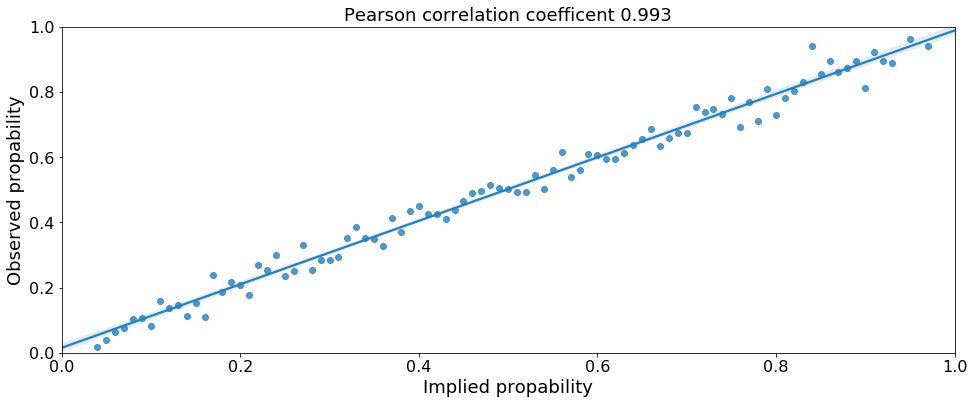

In [26]:
# group implied probabilities
_groupedby_object = df_bets.groupby(["Implied probability"])["Bet outcome"].mean()
_df = pd.DataFrame({'Observed probability': _groupedby_object}).reset_index()
# exclude outliers, data poitns with observed probability of 0 or 1
_df = _df[(_df["Observed probability"]<1) & (_df["Observed probability"]>0)]

# Calcualte Pearson coerelation cofficient
corr_coeff = _df["Implied probability"].corr(_df["Observed probability"]) 

# plot all data
plt.figure(figsize=(16, 6))
ax = sns.regplot(x="Implied probability", y="Observed probability", data=_df, color="#2980b9");
ax.set_title("Pearson correlation coefficent {:.3f}".format(corr_coeff), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("Implied propability", fontsize=18)
ax.set_ylabel("Observed propability", fontsize=18)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1);
plt.savefig("images/observed_prob_vs_implied_all_data.png", dpi=200, format="png", bbox_inches="tight");

### 3.1.2 NULL hypothesis for each league
Test whatever NULL hypothesis holds true for both leagues by analyzing them sepreratly.

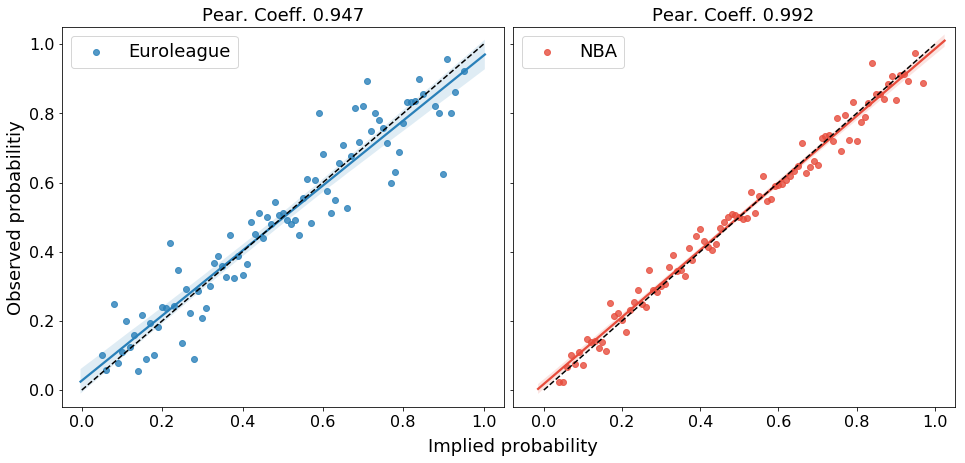

In [27]:
# group implied probabilities
_groupedby_object = df_bets.groupby(["League", "Implied probability"])["Bet outcome"].mean()
_df = pd.DataFrame({'Observed probability': _groupedby_object}).reset_index()
# exclude outliers, data poitns with observed probability of 0 or 1
_df = _df[(_df["Observed probability"]<1) & (_df["Observed probability"]>0)]

# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
# Euroleague
_df_euro = _df[_df["League"]=="EURO"]
# Calculate Pearson coerelation cofficient for Euroleague
corr_coeff_euro = _df_euro["Implied probability"].corr(_df_euro["Observed probability"])
ax1.tick_params(axis='both', which='major', labelsize=16)
sns.regplot(x="Implied probability", y="Observed probability", label="Euroleague",
            data=_df_euro, color="#2980b9", ax=ax1)
ax1.plot([0,1], [0,1], "k--")
ax1.set_xlabel(None)
ax1.set_ylabel("Observed probabilitiy", fontsize=18)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.legend(loc=0, fontsize=18)
ax1.set_title("Pear. Coeff. {:.3f}".format(corr_coeff_euro), fontsize=18)

# NBA
_df_nba = _df[_df["League"]=="NBA"]

# Calculate Pearson coerelation cofficient for NBA
corr_coeff_nba = _df_nba["Implied probability"].corr(_df_nba["Observed probability"]) 

sns.regplot(x="Implied probability", y="Observed probability", label="NBA",
            data=_df_nba, color="#e74c3c", ax=ax2)
ax2.set_xlabel("Implied probability", fontsize=18)
ax2.plot([0,1], [0,1], "k--")
ax2.set_ylabel(None)
ax2.set_xlim(-0.08, 1.05)
ax2.legend(loc=0, fontsize=18)
ax2.set_title("Pear. Coeff. {:.3f}".format(corr_coeff_nba), fontsize=18)

ax2.tick_params(axis='both', which='major', labelsize=16)

ax2.xaxis.set_label_coords(0, -0.08)
f.subplots_adjust(wspace=0.02)
plt.savefig("images/observed_prob_vs_implied_separate.png", dpi=200, format="png", bbox_inches="tight");

### 3.1.3 Make random sampling test

In [28]:
# number of closing odds w/ and 2/o arbitrage (divide by 2, because every bet has 2 outcomes)
_ = df_bets[df_bets["Total implied probability"]<1]["URL"].count()/2
print("{} arbitrage unique bets".format(_))
_ = df_bets[df_bets["Total implied probability"]>=1]["URL"].count()/2
print("{} normal unique bets".format(_))

8543.0 arbitrage unique bets
15484.0 normal unique bets


In [29]:
%%time
# study only bets which finished wihout arbitrage (total implied pobability >=1)
_df = df_bets[df_bets["Total implied probability"]>=1]
sim_results = dict()
for league in ["NBA", "EURO"]:
    # simulate 500 random from all 5 seasons for each League
    _data = list()
    if league=="NBA":
        no_of_bets = 500
    else:
        no_of_bets = 125
    for n in range(10000):
        sim_bets = _df[_df["League"]==league]["Net outcome"].sample(no_of_bets, replace=True).sum()
        # append return of investment (net outcome divided by number of unit bets and
        # multiplied by 100 to get procentages)
        _data.append(sim_bets/no_of_bets*100)
    sim_results[league] = _data

Wall time: 3min 2s


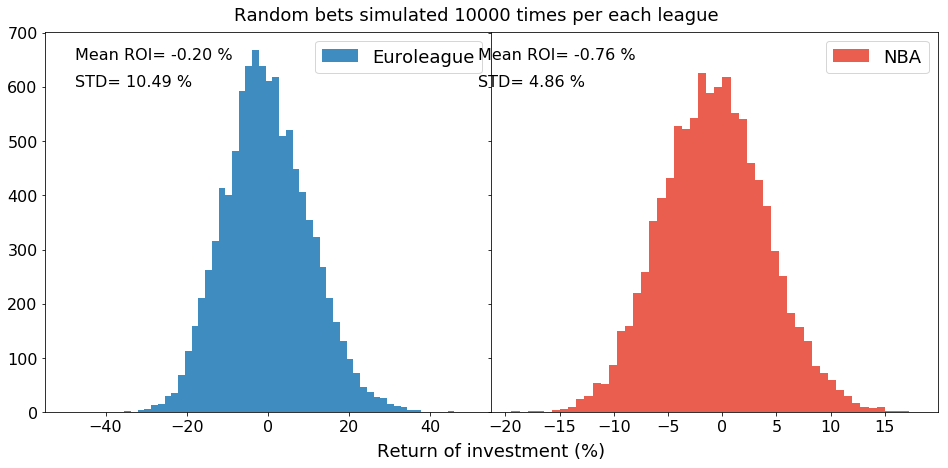

In [30]:
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,7))
f.suptitle('Random bets simulated 10000 times per each league', y=0.93, fontsize=18)

# Euroleague
ax1.hist(sim_results["EURO"], bins=50, label="Euroleague", color="#2980b9", alpha=0.9)
ax1.legend(loc=0, fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=16)
# calculate NBA ROI mean and std
mean_euro = np.mean(sim_results["EURO"])
std_euro = np.std(sim_results["EURO"])
ax1.text(-47.5, 650, "Mean ROI= {:.2f} %".format(mean_euro), fontsize=16)
ax1.text(-47.5, 600, "STD= {:.2f} %".format(std_euro), fontsize=16)
ax1.set_xlim(-55, 55)

# NBA
ax2.hist(sim_results["NBA"], bins=50, label="NBA", color="#e74c3c", alpha=0.9)
ax2.legend(loc=0, fontsize=18)
# calculate NBA ROI mean and std
mean_nba = np.mean(sim_results["NBA"])
std_nba = np.std(sim_results["NBA"])
ax2.text(-22.5, 650, "Mean ROI= {:.2f} %".format(mean_nba), fontsize=16)
ax2.text(-22.5, 600, "STD= {:.2f} %".format(std_nba), fontsize=16)
ax2.set_xlabel("Return of investment (%)", fontsize=18)
ax2.xaxis.set_label_coords(0, -0.08)
ax2.tick_params(axis='both', which='major', labelsize=16)
f.subplots_adjust(wspace=0.0)
plt.savefig("images/random_bet_simulations.png", dpi=200, format="png", bbox_inches="tight");

### Calculate confidence intervals alpha=99% for rejecting NULL hypothesis

In [31]:
euro_c1 = np.percentile(sim_results["EURO"], 2.5)
euro_c2 = np.percentile(sim_results["EURO"], 97.5)
nba_c1 = np.percentile(sim_results["NBA"], 2.5)
nba_c2 = np.percentile(sim_results["NBA"], 97.5)
print("Random betting 95% confidence intervals:")
print("Euroleague ({:.2f}, {:.2f})".format(euro_c1, euro_c2))
print("NBA ({:.2f}, {:.2f})".format(nba_c1, nba_c2))

Random betting 95% confidence intervals:
Euroleague (-19.49, 21.26)
NBA (-9.93, 9.08)


## 3.2 Totals betting market analysis
Totals- total points scored per game by both teams. Let's investigate, whatever some paterns could be found.

### 3.2.1 total points score per game

In [32]:
# Total points per League per Season
df.groupby(["League", "Season"])["Total"].mean().round(2)

League  Season   
EURO    2013/2014    151.51
        2014/2015    155.80
        2015/2016    154.53
        2016/2017    158.17
        2017/2018    161.61
NBA     2013/2014    201.07
        2014/2015    200.05
        2015/2016    204.67
        2016/2017    210.88
        2017/2018    212.25
Name: Total, dtype: float64

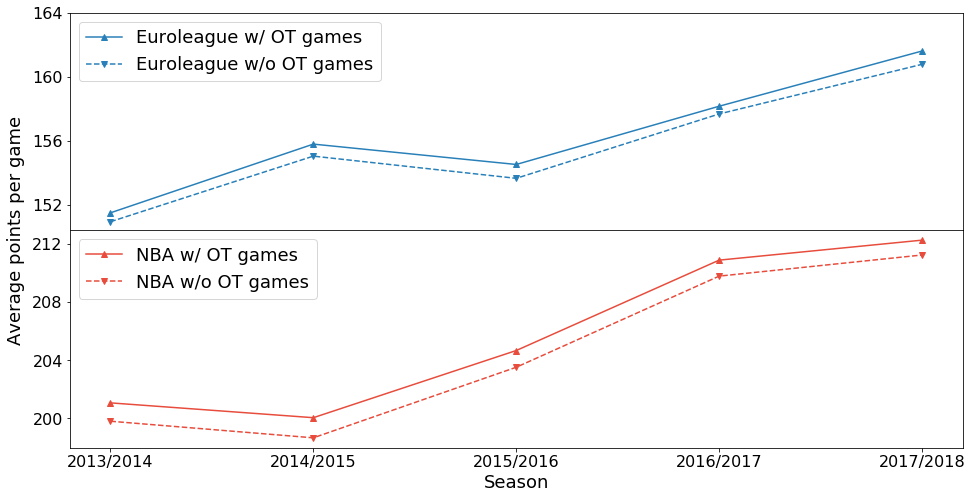

In [33]:
# split DataFrames into NBA and Euroleague DataFrames
df_euro = df[df.League == 'EURO']
df_nba = df[df.League == 'NBA']

# total scored points including games finished with overtime
total_euro = df_euro.groupby(['Season'])['Total'].mean()
total_nba = df_nba.groupby(['Season'])['Total'].mean()

# total scored points excluding games finished with overtime
total_ot_euro = df_euro[df_euro.OT!=1].groupby(['Season'])['Total'].mean()
total_ot_nba = df_nba[df_nba.OT!=1].groupby(['Season'])['Total'].mean()

# plot results
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))
# Euroleague
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(total_euro.index, total_euro.values, "^-", color="#2980b9", label="Euroleague w/ OT games")
ax1.plot(total_ot_euro.index, total_ot_euro.values, "v--", color="#2980b9", label="Euroleague w/o OT games")
ax1.legend(fontsize=18)
ax1.set_yticks([152, 156, 160, 164])
# NBA
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(total_nba.index, total_nba.values, "^-", color="#e74c3c", label="NBA w/ OT games")
ax2.plot(total_ot_nba.index, total_ot_nba.values, "v--", color="#e74c3c", label="NBA w/o OT games")
ax2.legend(fontsize=18)
ax2.set_yticks([200, 204, 208, 212])
ax2.set_xlabel("Season", fontsize=18)
ax2.set_ylabel("Average points per game", fontsize=18)
ax2.xaxis.set_label_coords(0.5, -0.12)
ax2.yaxis.set_label_coords(-0.05, 1.0)
f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/total_points.png", dpi=200, format="png", bbox_inches="tight")

###  How Totals markets correlate with total points scored

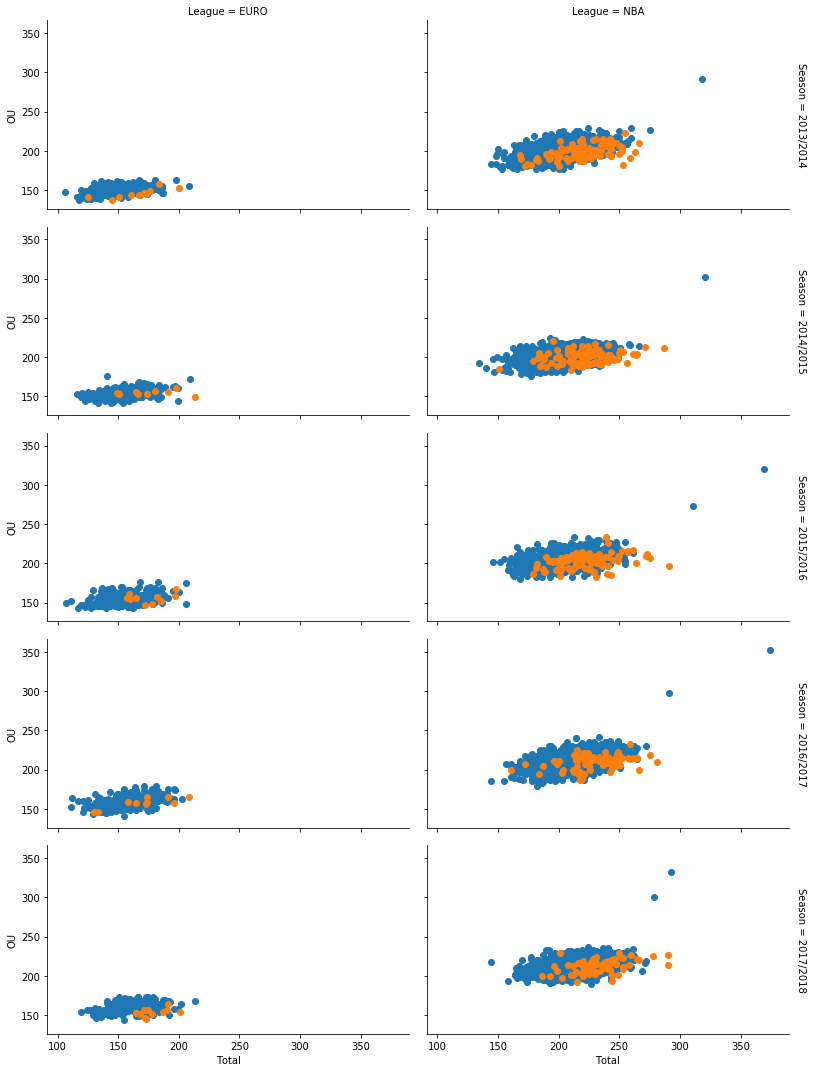

In [34]:
g = sns.FacetGrid(df, row="Season", col="League", hue="OT", margin_titles=True, height=3, aspect=1.9)
g.map(plt.scatter, "Total", "OU");

In [35]:
# investigate outliers
df[df.OU>250].sort_values("Date")[["Date", "Home_name", "Away_name", "OU", "Total"]]

,Date,Home_name,Away_name,OU,Total
1809,2014-02-17 03:00:00,East,West,291.0,318.0
3218,2015-02-16 03:30:00,East,West,301.5,321.0
4713,2016-02-13 04:00:00,Team World,Team USA,272.5,311.0
4712,2016-02-15 03:00:00,East,West,320.5,369.0
6081,2017-02-18 04:00:00,Team USA,Team World,297.5,291.0
6080,2017-02-20 03:00:00,West,East,352.0,374.0
7388,2018-02-17 04:00:00,Team USA,Team World,301.0,279.0
7387,2018-02-19 03:00:00,Team Stephen,Team LeBron,332.5,293.0


There are some special games during season when NBA players play for fun, hence many more points are scored during the match.

### Let's investigate whatever average scored points per month change during season

In [36]:
_df = df.copy()
# add month column
_df['Month'] = _df['Date'].map(lambda x: int(x.month))
# exclude Spetember, because only 9 games were played in total
_df = _df[_df.Month!=9]
# rename Months from numbers to abreviations
_df["Month"] = _df["Month"].map({1:"Jan", 2:"Feb", 3: "Mar", 4: "Apl", 5: "May", 6: "Jun", 7: "Jul",
                                 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})
_df.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,Total,Month
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,86.0,98.0,0,1,1.18,6.75,184.0,May
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,2014-05-18 18:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,93.0,78.0,1,0,1.82,2.26,171.0,May
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,2014-05-16 22:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,62.0,100.0,0,0,2.58,1.70,162.0,May
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,67.0,68.0,0,0,1.40,3.60,135.0,May
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,2014-04-25 21:45:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,83.0,69.0,1,0,1.27,5.70,152.0,Apl


Check wahtever totals points scored increases during the season

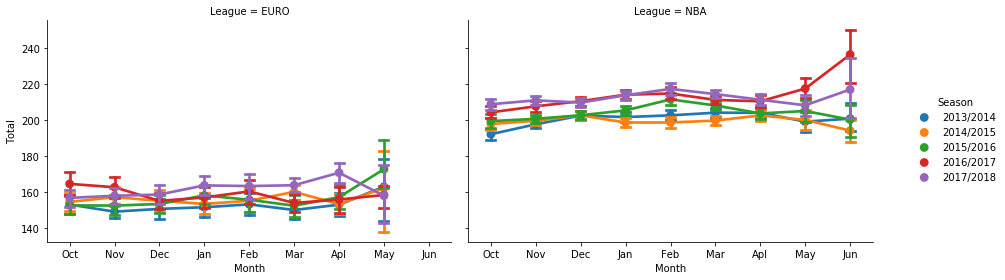

In [37]:
g = sns.catplot(x="Month", y="Total", hue="Season", col="League",
                capsize=.2, height=4, aspect=1.6,
                kind="point", data=_df, margin_titles=True,
                order=["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apl", "May", "Jun"])

No clearly defined trend of more points scored as season progresses is observed.

### 3.2.2 Over/under bets 
One can observe that in both leagues average points scored per game increased. This raises a question "whatever markets ajust to this or can we exploy it?".

In [38]:
# make datetime DataFrame's index
_df = df_bets[df_bets["Bet type"] == "OU"].copy()
# create new collumn which tells whatever bet was on over
_df["Bet subtype"] = _df["Bet subtype"].apply(lambda x: "Over" if x[:4]=="Over" else "Under")
# drop voided bets
_df = _df.dropna()
# filter out Under bets, so no duplicates would be present
_df = _df[_df["Bet subtype"]=="Over"]
# add month column
_df['Month'] = _df['Date'].map(lambda x: int(x.month))
# exclude Spetember, because only 9 games were played in total
_df = _df[_df.Month!=9]
# rename Months from numbers to abreviations
_df["Month"] = _df["Month"].map({1:"Jan", 2:"Feb", 3: "Mar", 4: "Apl", 5: "May", 6: "Jun", 7: "Jul",
                                 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"})
_df.head()

,Bet type,Bet subtype,Odds,Net outcome,Total implied probability,URL,Bet outcome,Implied probability,Home_name,Away_name,Date,League,Season,Month
6,OU,Over,2.05,1.05,1.000625,https://www.oddsportal.com/basketball/europe/e...,1.0,0.49,Barcelona,CSKA Moscow,2014-05-18 18:00:00,EURO,2013/2014,May
12,OU,Over,2.10,1.10,0.983805,https://www.oddsportal.com/basketball/europe/e...,1.0,0.48,Barcelona,Real Madrid,2014-05-16 22:00:00,EURO,2013/2014,May
18,OU,Over,2.06,-1.00,0.998257,https://www.oddsportal.com/basketball/europe/e...,0.0,0.49,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,EURO,2013/2014,May
24,OU,Over,2.01,-1.00,1.021073,https://www.oddsportal.com/basketball/europe/e...,0.0,0.50,Real Madrid,Olympiakos,2014-04-25 21:45:00,EURO,2013/2014,Apl
30,OU,Over,1.96,-1.00,1.012717,https://www.oddsportal.com/basketball/europe/e...,0.0,0.51,CSKA Moscow,Panathinaikos,2014-04-25 19:00:00,EURO,2013/2014,Apl


In [39]:
# bet only on overs, multyply by 100 to get percentages
_returns = _df.groupby(["League", "Season", "Month"])["Net outcome"].mean()*100
_df = pd.DataFrame({"Returns": _returns}).reset_index()
_df.head()

,League,Season,Month,Returns
0,EURO,2013/2014,Apl,13.148148
1,EURO,2013/2014,Dec,-6.657143
2,EURO,2013/2014,Feb,-0.909091
3,EURO,2013/2014,Jan,17.236842
4,EURO,2013/2014,Mar,-7.967742


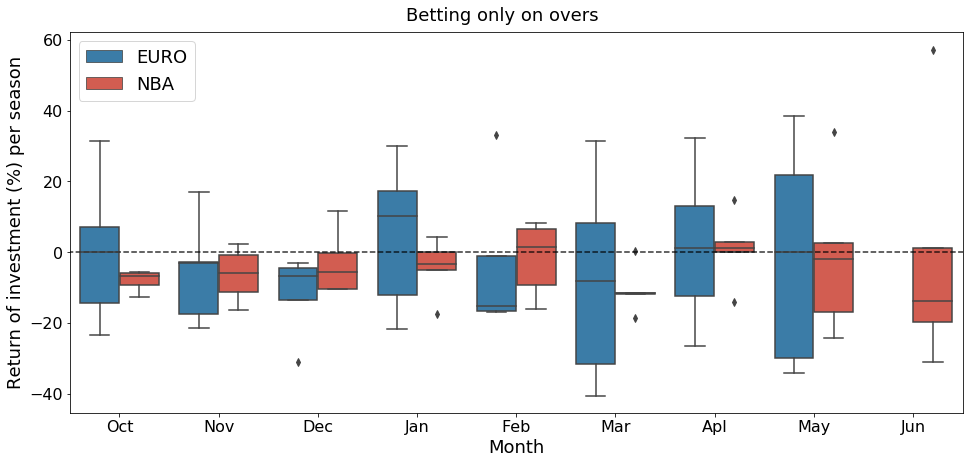

In [40]:
# plot results
f, ax1 = plt.subplots(figsize=(16,7))
f.suptitle('Betting only on overs', y=0.93, fontsize=18)
# exclude semptember because of low amout of data
sns.boxplot(x="Month", y="Returns", hue="League", data=_df, ax=ax1, palette=["#2980b9", "#e74c3c"],
           order=["Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apl", "May", "Jun"])
ax1.plot([-1, 13], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("Return of investment (%) per season", fontsize=18)
ax1.set_xlabel("Month", fontsize=18)
ax1.legend(loc=2, fontsize=18);
# Save figure
plt.savefig("images/betting_on_overs_only.png", dpi=200, format="png", bbox_inches="tight")

### Let's investigate first observation
Betting on only for unders at the begining of NBA season should result in net positive returns.

In [53]:
# enter conditions
_df = df_bets[df_bets["Bet type"] == "OU"].copy()
# create new collumn which tells whatever bet was on over
_df["Bet subtype"] = _df["Bet subtype"].apply(lambda x: "Over" if x[:4]=="Over" else "Under")
# add month column
_df['Month'] = _df['Date'].map(lambda x: int(x.month))
cond_1 = _df["Bet subtype"] == "Under" # get only over/under markets
cond_2 = _df["Month"] == 10 # get only October matches
cond_3 = _df["League"] == "NBA" # bet only on NBA
units = _df[cond_1 & cond_2 & cond_3]["Net outcome"].sum()
ROI = _df[cond_1 & cond_2 & cond_3]["Net outcome"].mean()*100
bets_placed = _df[cond_1 & cond_2 & cond_3]["Net outcome"].count() 
print("{:.0f} bets placed".format(bets_placed))
print("{:.2f} units won".format(units))
print("{:.2f}% ROI".format(ROI))

657 bets placed
48.44 units won
7.37% ROI


In [54]:
# get number of bets per season
_df[cond_1 & cond_2 & cond_3].groupby("Season")["URL"].count()

Season
2013/2014    121
2014/2015    117
2015/2016    124
2016/2017    128
2017/2018    167
Name: URL, dtype: int64

In [49]:
# get returns per season
_df[cond_1 & cond_2 & cond_3].groupby("Season")["Net outcome"].sum()

Season
2013/2014    13.00
2014/2015     5.36
2015/2016     7.99
2016/2017    11.15
2017/2018    10.94
Name: Net outcome, dtype: float64

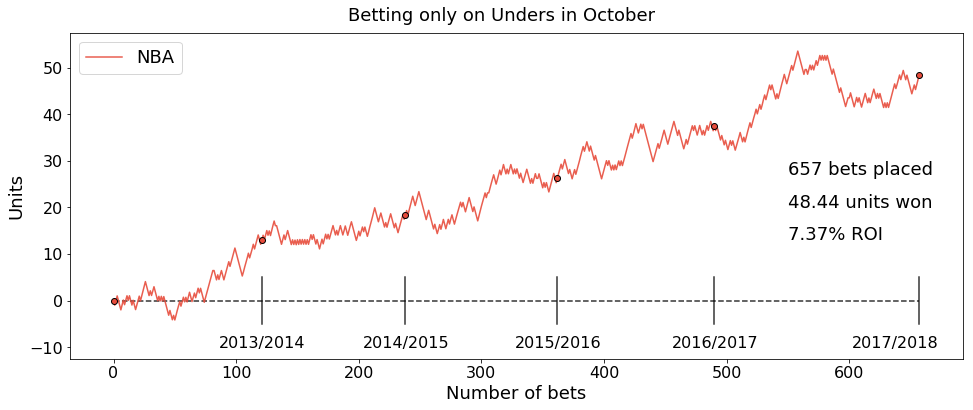

In [57]:
# plot results
f, ax1 = plt.subplots(figsize=(16,6))
f.suptitle('Betting only on Unders in October', y=0.94, fontsize=18)

# get bet numbers
X = pd.Series(np.arange(0, _df[cond_1 & cond_2 & cond_3].shape[0]+1)).values
# get cummunitative sum for bets
Y = _df[cond_1 & cond_2 & cond_3]["Net outcome"].cumsum().values
Y = np.append([0], Y)
# baseline
ax1.plot([0, 657], [0, 0], "k--", alpha=0.8)
ax1.plot(Y, label="NBA", color="#e74c3c", alpha=0.9)
# manually add ticks where season ended (for text substract 35 from x position)
ax1.plot([121, 121], [5, -5], "k-", alpha=0.8)
ax1.text(86, -10, "2013/2014", fontsize=16)
ax1.plot([238, 238], [5, -5], "k-", alpha=0.8)
ax1.text(203, -10, "2014/2015", fontsize=16)
ax1.plot([362, 362], [5, -5], "k-", alpha=0.8)
ax1.text(327, -10, "2015/2016", fontsize=16)
ax1.plot([490, 490], [5, -5], "k-", alpha=0.8)
ax1.text(455, -10, "2016/2017", fontsize=16)
ax1.plot([657, 657], [5, -5], "k-", alpha=0.8)
ax1.text(602, -10, "2017/2018", fontsize=16)
# manually show unit change over seasons
ax1.scatter([0, 121, 238, 362, 490, 657], [0, 13, 18.36, 26.35, 37.5, 48.44],
            color="#e74c3c", edgecolors='k', zorder=10)

ax1.text(550, 27, "{:.0f} bets placed".format(bets_placed), fontsize=18)
ax1.text(550, 20, "{:.2f} units won".format(units), fontsize=18)
ax1.text(550, 13, "{:.2f}% ROI".format(ROI), fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("Units", fontsize=18)
ax1.set_xlabel("Number of bets", fontsize=18);
ax1.set_ylim(-12.5, 57.5)
ax1.legend(loc=2, fontsize=18);
# Save figure
plt.savefig("images/NBA_under_bets.png", dpi=200, format="png", bbox_inches="tight")

### Let's investigate second observation
Betting on only for unders in Janury during Euroleague season should result in net positive returns.

In [58]:
# enter conditions
_df = df_bets[df_bets["Bet type"] == "OU"].copy()
# create new collumn which tells whatever bet was on over
_df["Bet subtype"] = _df["Bet subtype"].apply(lambda x: "Over" if x[:4]=="Over" else "Under")
# add month column
_df['Month'] = _df['Date'].map(lambda x: int(x.month))
cond_1 = _df["Bet subtype"] == "Under" # get only over/under markets
cond_2 = _df["Month"] == 12 # get only October matches
cond_3 = _df["League"] == "EURO" # bet only on Euroleague
units = _df[cond_1 & cond_2 & cond_3]["Net outcome"].sum()
ROI = _df[cond_1 & cond_2 & cond_3]["Net outcome"].mean()*100
bets_placed = _df[cond_1 & cond_2 & cond_3]["Net outcome"].count()
print("{:.0f} bets placed".format(bets_placed))
print("{:.2f} units won".format(units))
print("{:.2f}% ROI".format(ROI))

203 bets placed
26.98 units won
13.29% ROI


In [59]:
# get number of bets per season
_df[cond_1 & cond_2 & cond_3].groupby("Season")["URL"].count()

Season
2013/2014    35
2014/2015    35
2015/2016    44
2016/2017    47
2017/2018    42
Name: URL, dtype: int64

In [60]:
# get returns per season
_df[cond_1 & cond_2 & cond_3].groupby("Season")["Net outcome"].sum()

Season
2013/2014     2.87
2014/2015     1.02
2015/2016     6.38
2016/2017    14.99
2017/2018     1.72
Name: Net outcome, dtype: float64

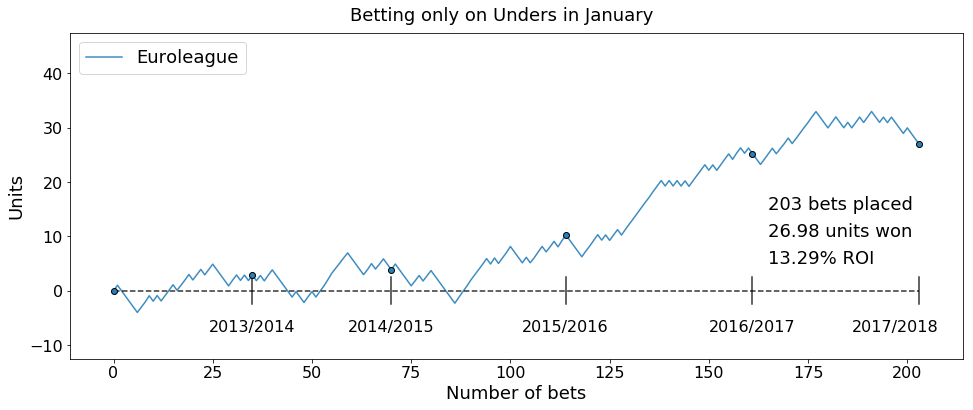

In [64]:
# plot results
f, ax1 = plt.subplots(figsize=(16,6))
f.suptitle('Betting only on Unders in January', y=0.94, fontsize=18)
# get bet numbers
X = pd.Series(np.arange(0, _df[cond_1 & cond_2 & cond_3].shape[0]+1)).values
# get cummunitative sum for bets
Y = _df[cond_1 & cond_2 & cond_3]["Net outcome"].cumsum().values
Y = np.append([0], Y)
ax1.plot(X, Y, label="Euroleague", color="#2980b9", alpha=0.9)
ax1.plot([0, 203], [0, 0], "k--", alpha=0.8)
# manually add ticks where season ended (for text substract 11 from x position)
ax1.plot([35, 35], [2.5, -2.5], "k-", alpha=0.8)
ax1.text(24, -7.5, "2013/2014", fontsize=16)
ax1.plot([70, 70], [2.5, -2.5], "k-", alpha=0.8)
ax1.text(59, -7.5, "2014/2015", fontsize=16)
ax1.plot([114, 114], [2.5, -2.5], "k-", alpha=0.8)
ax1.text(103, -7.5, "2015/2016", fontsize=16)
ax1.plot([161, 161], [2.5, -2.5], "k-", alpha=0.8)
ax1.text(150, -7.5, "2016/2017", fontsize=16)
ax1.plot([203, 203], [2.5, -2.5], "k-", alpha=0.8)
ax1.text(186, -7.5, "2017/2018", fontsize=16)
# manually show unit change over seasons
ax1.scatter([0, 35, 70, 114, 161, 203], [0, 2.87, 3.89, 10.27, 25.26, 26.98],
            color="#2980b9", edgecolors='k', zorder=10)

ax1.text(165, 15, "{:.0f} bets placed".format(bets_placed), fontsize=18)
ax1.text(165, 10, "{:.2f} units won".format(units), fontsize=18)
ax1.text(165, 5, "{:.2f}% ROI".format(ROI), fontsize=18)

ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("Units", fontsize=18)
ax1.set_xlabel("Number of bets", fontsize=18);
ax1.set_ylim(-12.5, 47.5)
ax1.legend(loc=2, fontsize=18);
# Save figure
plt.savefig("images/EURO_under_bets.png", dpi=200, format="png", bbox_inches="tight")

### Number of games per month
Check whatever number of matches per month might distorts statistics.

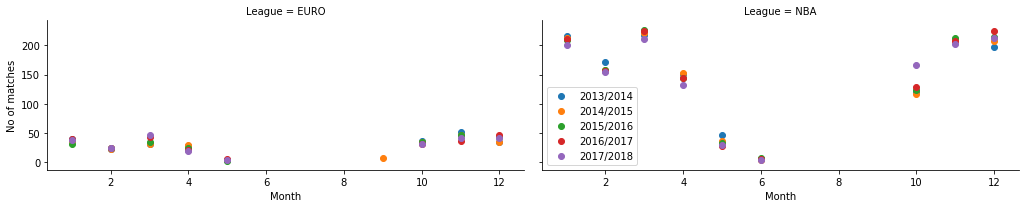

In [49]:
_df = pd.DataFrame({"No of matches": _df.groupby(["League", "Season", "Month"])["URL"].nunique()}).reset_index()
g = sns.FacetGrid(_df, col="League", hue="Season", margin_titles=True, height=3, aspect=2.4)
g.map(plt.scatter, "Month", "No of matches");
plt.legend();

It seems that slightly less games are player in october. This might be an outlier 

### How OU market prediction reflect Totals distribution
Figure bellow shows distribution of Total points scored and predicted OU values for NBA and Euroleague.

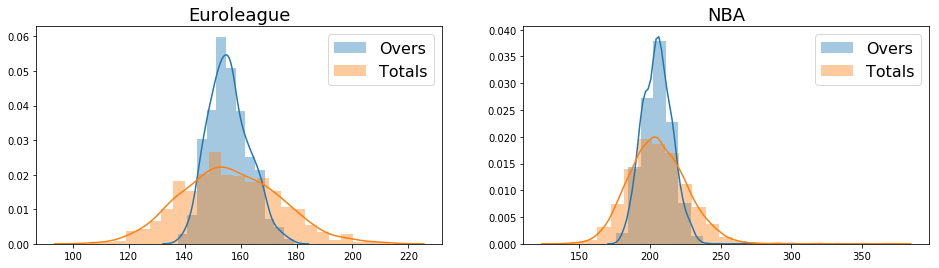

In [50]:
# plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
# Euroleague
sns.distplot(df[df.League=="EURO"].OU.values, label="Overs", bins=12, ax=ax1)
sns.distplot(df[df.League=="EURO"].Total.values, label="Totals", bins=25, ax=ax1)
ax1.legend(fontsize=16);
ax1.set_title("Euroleague", fontsize=18);

# NBA
sns.distplot(df[df.League=="NBA"].OU.values, label="Overs", bins=20, ax=ax2)
sns.distplot(df[df.League=="NBA"].Total.values, label="Totals", bins=25, ax=ax2)
ax2.legend(fontsize=16);
ax2.set_title("NBA", fontsize=18);

### 3.2.3 Even or Odds
It is well know that to predict whatever game will fiinish with even or odds points is totaly rundom. Just just for fun, let's investigate both Euroleague and NBA games.

In [51]:
_df = df.copy()
# Evens will be 0 and and odds 1
_df["Odds or Even"] = _df["Total"].apply(lambda x: 0 if x%2==0 else 1)
_df.head()

,AH,AH_Home,AH_Away,OU,Over,Under,Home_name,Away_name,Date,URL,League,Season,Home_score,Away_score,Win,OT,Home_p,Away_p,Total,Odds or Even
0,-10.5,1.95,2.12,157.5,2.02,2.06,Real Madrid,Maccabi Tel Aviv,2014-05-18 21:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,86.0,98.0,0,1,1.18,6.75,184.0,0
1,-2.5,1.98,2.02,151.5,2.05,1.95,Barcelona,CSKA Moscow,2014-05-18 18:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,93.0,78.0,1,0,1.82,2.26,171.0,1
2,2.5,1.95,2.20,155.5,2.10,1.97,Barcelona,Real Madrid,2014-05-16 22:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,62.0,100.0,0,0,2.58,1.70,162.0,0
3,-6.5,1.95,2.08,147.5,2.06,1.95,CSKA Moscow,Maccabi Tel Aviv,2014-05-16 19:00:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,67.0,68.0,0,0,1.40,3.60,135.0,1
4,-8.5,2.03,1.95,153.5,2.01,1.91,Real Madrid,Olympiakos,2014-04-25 21:45:00,https://www.oddsportal.com/basketball/europe/e...,EURO,2013/2014,83.0,69.0,1,0,1.27,5.70,152.0,0


In [52]:
# proportion of games finished with odd number of points
_df.groupby(["League", "Season"])["Odds or Even"].mean().round(3)

League  Season   
EURO    2013/2014    0.484
        2014/2015    0.576
        2015/2016    0.480
        2016/2017    0.521
        2017/2018    0.518
NBA     2013/2014    0.524
        2014/2015    0.518
        2015/2016    0.492
        2016/2017    0.526
        2017/2018    0.530
Name: Odds or Even, dtype: float64

In [53]:
# proportion of games finished with even number of points
1 - _df.groupby(["League", "Season"])["Odds or Even"].mean().round(3)

League  Season   
EURO    2013/2014    0.516
        2014/2015    0.424
        2015/2016    0.520
        2016/2017    0.479
        2017/2018    0.482
NBA     2013/2014    0.476
        2014/2015    0.482
        2015/2016    0.508
        2016/2017    0.474
        2017/2018    0.470
Name: Odds or Even, dtype: float64

In [54]:
print("All matches:")
print("Odd {}%".format(_df["Odds or Even"].mean().round(3)*100))
print("Even {}%".format(100-_df["Odds or Even"].mean().round(3)*100))

All matches:
Odd 51.7%
Even 48.3%


### Fun/stupid strategy
Let's allways bet that game will finish with even score (largest available coefficeints are 1.95). What will be our returns?

In [55]:
_df["Odds/Even Returns"] = _df["Odds or Even"].apply(lambda x: 0.95 if x==1 else -1)
print("{} bets placed".format(_df["Odds/Even Returns"].count()))
print("ROI {:.2f}%".format(_df["Odds/Even Returns"].mean()*100))

8319 bets placed
ROI 0.91%


Plot below is just for fun. This strategy is definetly not practical.

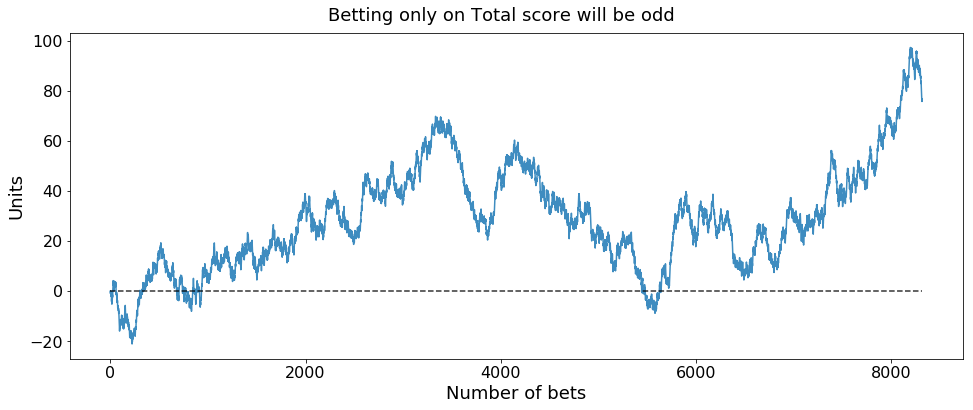

In [56]:
# plot results
f, ax1 = plt.subplots(figsize=(16,6))
f.suptitle('Betting only on Total score will be odd', y=0.94, fontsize=18)
# get bet numbers
X = pd.Series(np.arange(0, _df.shape[0]+1)).values
# get cummunitative sum for bets
Y =_df["Odds/Even Returns"].cumsum().values
Y = np.append([0], Y)
ax1.plot(X, Y, color="#2980b9", alpha=0.9)
ax1.plot([0, _df.shape[0]], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylabel("Units", fontsize=18)
ax1.set_xlabel("Number of bets", fontsize=18);
# Save figure
plt.savefig("images/bet_only_odds.png", dpi=200, format="png", bbox_inches="tight")

Too small ROI to justify such betting strategy (falls in 95% confidence interval).

## 3.3 Team performances
Let's investigate whatever blindly supporting single team might have a positive or very negative returns.

### 3.3.1 Analyze Head to head (H2H) games
One might expect that teams with high odds, i.e. whose unlikely to win, might have better returns. 

In [57]:
%%time
# copy only head to head bets
_df = df_bets[df_bets["Bet type"]=="H2H"].copy().reindex()

_results = list()
# iterate over unique match links
for url in _df.URL.unique():
    # take only H2H data for particular match
    _data = _df[_df.URL == url].reindex()
    # home team outcome
    _home = _data.iloc[0]
    _results.append([_home["Home_name"], _home["Bet subtype"], _home["URL"], _home["Net outcome"],
                    _home["League"], _home["Season"]])
    # away team outcome
    _away = _data.iloc[1]
    _results.append([_away["Away_name"], _away["Bet subtype"], _away["URL"], _away["Net outcome"],
                    _away["League"], _away["Season"]])
    
# save it to new DataFrame
_df = pd.DataFrame(_results, columns=["Team name", "Bet subtype", "URL", "Net outcome", "League", "Season"])

Wall time: 41.1 s


In [58]:
_df.head()

,Team name,Bet subtype,URL,Net outcome,League,Season
0,Real Madrid,Home,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014
1,Maccabi Tel Aviv,Away,https://www.oddsportal.com/basketball/europe/e...,5.75,EURO,2013/2014
2,Barcelona,Home,https://www.oddsportal.com/basketball/europe/e...,0.82,EURO,2013/2014
3,CSKA Moscow,Away,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014
4,Barcelona,Home,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014


In [59]:
_returns = _df.groupby(["League", "Team name", "Season"])["Net outcome"].sum()
_df2 = pd.DataFrame({"Season returns": _returns}).reset_index()
# get only team names which aprticipated in all 5 seasons
team_names = _df2["Team name"].value_counts()[_df2["Team name"].value_counts()==5].index
_df2 = _df2[_df2['Team name'].isin(team_names)]
_df2.head()

,League,Team name,Season,Season returns
1,EURO,Anadolu Efes,2013/2014,-13.21
2,EURO,Anadolu Efes,2014/2015,-0.39
3,EURO,Anadolu Efes,2015/2016,-3.20
4,EURO,Anadolu Efes,2016/2017,0.94
5,EURO,Anadolu Efes,2017/2018,-5.83


### Teams with highest total returns over last 5 seasons
* check total returns,
* check mean returns,
* check standard deviation (STD) of returns.

In [60]:
_group = _df2.groupby(["League", "Team name"])["Season returns"].agg({'sum':'sum', 
                                                                      'mean':'mean',
                                                                      'std':'std'}) 
_group.sort_values(['sum', 'mean', 'std'], ascending=[False, False, True])
# _group.sort_values(['std'], ascending=[True])

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


sum    mean        std
League Team name                                       
NBA    Boston Celtics          59.71  11.942  16.533911
       Memphis Grizzlies       45.96   9.192  17.691788
       Chicago Bulls           30.96   6.192   6.040486
EURO   Baskonia                28.86   5.772   8.579759
       Fenerbahce              28.41   5.682   5.375172
NBA    Miami Heat              28.29   5.658   8.730872
       Houston Rockets         27.94   5.588   9.301106
EURO   Zalgiris Kaunas         26.85   5.370   7.923027
NBA    Toronto Raptors         26.05   5.210   9.119416
       Portland Trail Blazers  25.78   5.156   7.854774
       Los Angeles Lakers      24.09   4.818  11.079317
       Indiana Pacers          23.63   4.726  11.158962
EURO   Crvena zvezda mts       22.62   4.524   6.550464
NBA    Atlanta Hawks           21.32   4.264  12.016176
EURO   Olympiakos              18.82   3.764   4.763956
NBA    Washington Wizards      18.21   3.642   5.707764
       Utah Jazz               14.20   2.840  17.104209
       Los Angeles Clippers    14.00   2.800   4.585264
       Sacramento Kings        12.77   2.554  17.144902
       Golden State Warriors   11.86   2.372   7.414123
       New Orleans Pelicans     7.56   1.512   9.272015
       Brooklyn Nets            3.65   0.730  14.011242
EURO   Maccabi Tel Aviv         3.33   0.666   7.420480
NBA    San Antonio Spurs        3.02   0.604   8.243575
EURO   CSKA Moscow              2.37   0.474   2.187997
NBA    Denver Nuggets           0.24   0.048  12.452509
       Charlotte Hornets       -1.69  -0.338  20.719308
       Phoenix Suns            -2.15  -0.430  18.748143
       Cleveland Cavaliers     -2.38  -0.476  11.498893
       New York Knicks         -5.73  -1.146   8.441332
EURO   Olimpia Milano          -8.85  -1.770   5.825547
       Real Madrid             -9.64  -1.928   4.906737
NBA    Dallas Mavericks       -10.79  -2.158  10.013008
       Oklahoma City Thunder  -18.99  -3.798   6.382983
EURO   Barcelona              -19.52  -3.904   6.263236
NBA    Detroit Pistons        -20.40  -4.080   8.668994
EURO   Panathinaikos          -21.28  -4.256   1.944577
       Anadolu Efes           -21.69  -4.338   5.605298
NBA    Minnesota Timberwolves -30.41  -6.082  14.400995
       Orlando Magic          -34.61  -6.922   7.944795
       Milwaukee Bucks        -48.01  -9.602  21.142906
       Philadelphia 76ers     -55.09 -11.018  23.959844

### Main observations
* Largest ammount of money was lost blindly betting on `Philadelphia 76ers` and `Anadolu Efes` for NBA and Euroleague, respectively.
* Largest ammount of money was won blindly betting on `Boston Celtics` and `Baskonia` for NBA and Euroleague, respectively.

Let's investigate whatever this data is not distorted by single good season.
#### Euroleague team performance

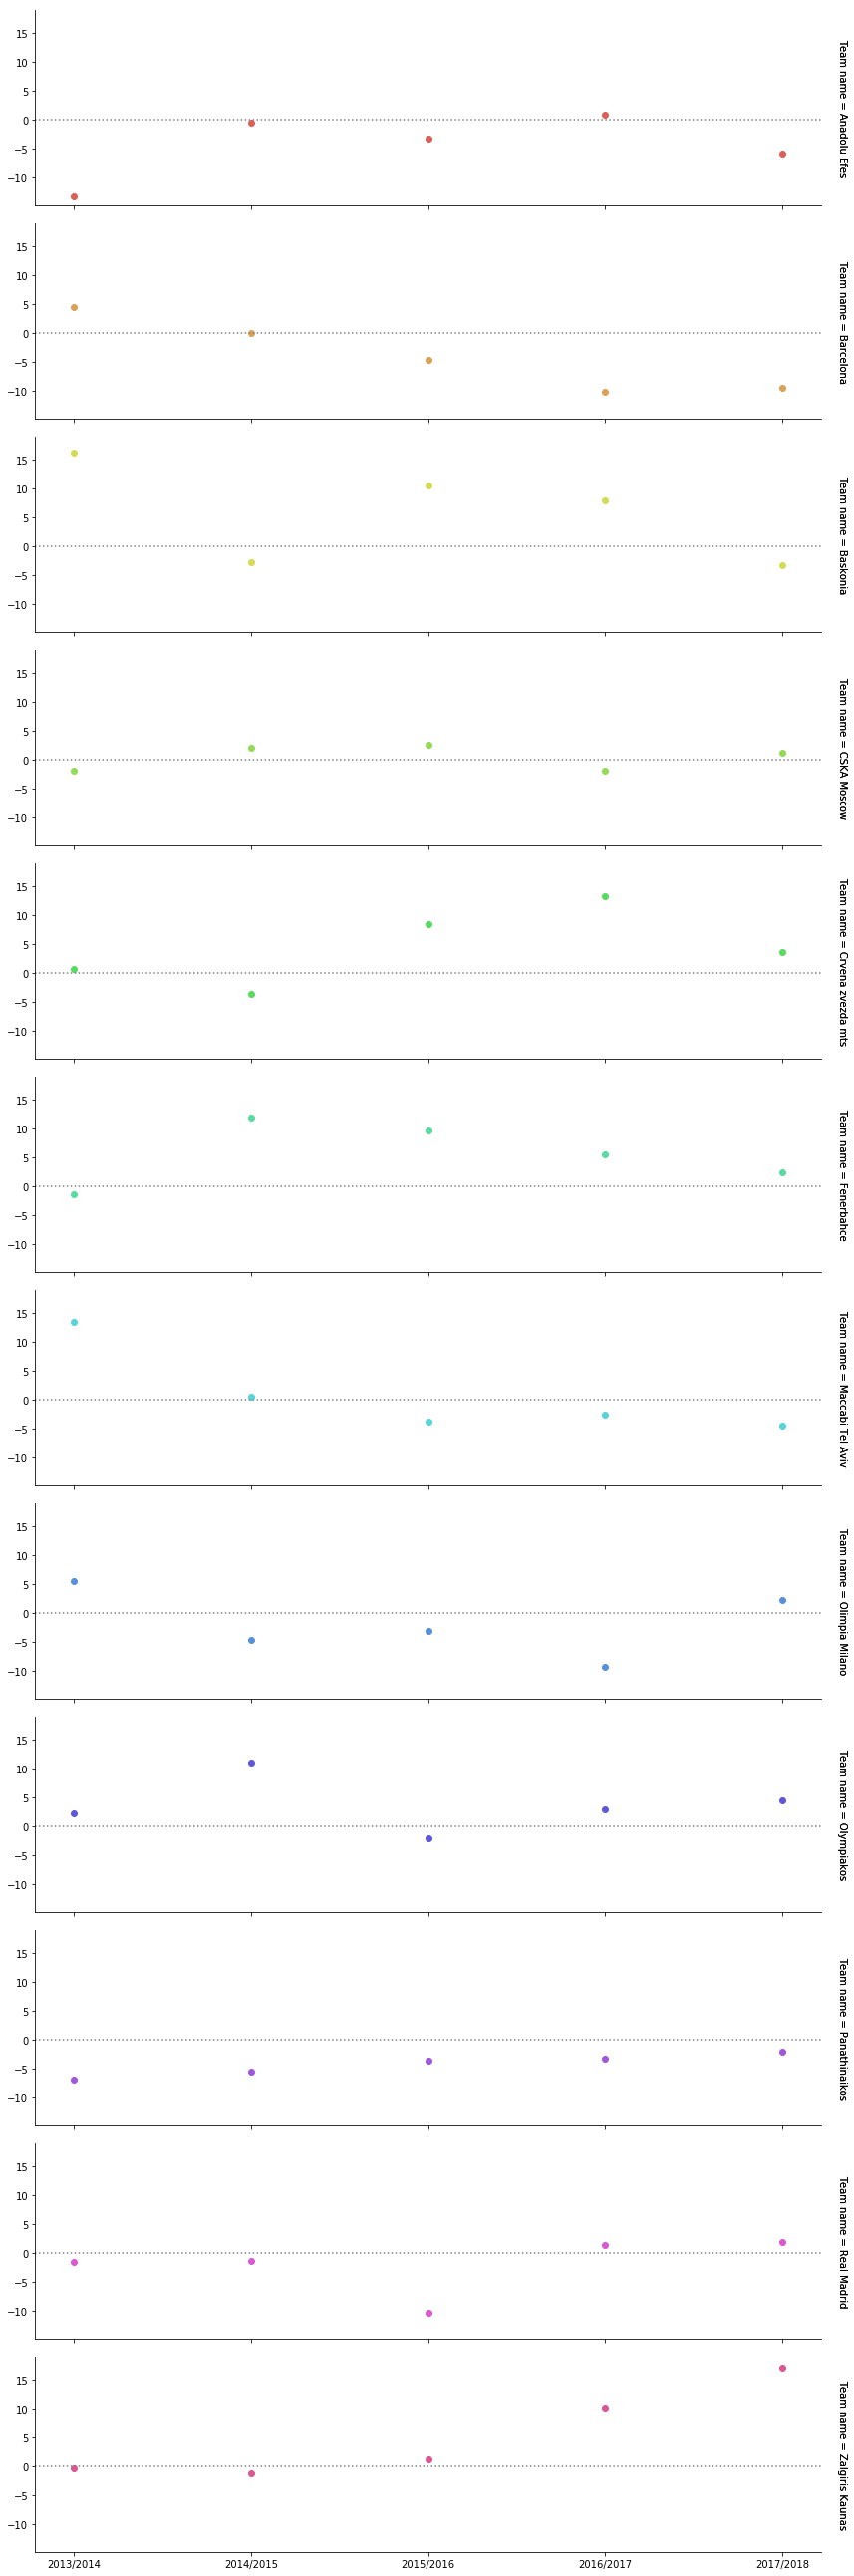

In [61]:
g = sns.FacetGrid(_df2[_df2.League=="EURO"], row="Team name", hue="Team name",
                  margin_titles=True, height=3, aspect=4, palette="hls")
g.map(plt.scatter, "Season", "Season returns");
# Draw a horizontal line to show 0 sum
g.map(plt.axhline, y=0, ls=":", c=".5");

### 3.3.2 Most interesting H2H teams
Plot different betting strategies for different teams.

In [62]:
# create DataFrames for each Euroleague team
df_pana = _df[_df["Team name"]=="Panathinaikos"]
df_cska = _df[_df["Team name"]=="CSKA Moscow"]
df_fene = _df[_df["Team name"]=="Fenerbahce"]

In [63]:
# check when seasons ended
df_fene.groupby(["Season"])["Net outcome"].agg({'sum':'sum',
                                                'count':'count'}) 

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,sum,count
Season,,
2013/2014,-1.36,23
2014/2015,12.00,29
2015/2016,9.65,29
2016/2017,5.65,35
2017/2018,2.47,34


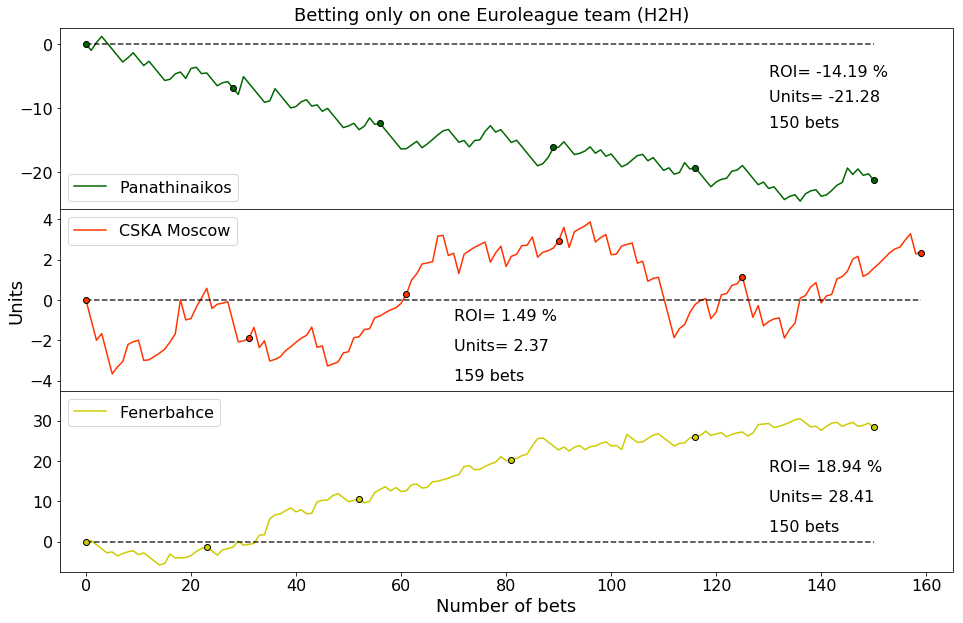

In [64]:
# plot results
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,10))
f.suptitle('Betting only on one Euroleague team (H2H)', y=0.91, fontsize=18)

# Panathinaikos
X1 = pd.Series(np.arange(0, df_pana.shape[0]+1)).values
# get cummunitative sum for bets
Y1 = df_pana["Net outcome"].cumsum().values
Y1 = np.append([0], Y1)
ax1.plot(X1, Y1, color="#006600", label="Panathinaikos")
ax1.plot([0, df_pana.shape[0]], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=16);
# manually show unit change over seasons
ax1.scatter([0, 28, 56, 89, 116, 150], [0, -6.89, -12.41, -16.04, -19.31, -21.28],
            color="#006600", edgecolors='k', zorder=10)
# calculate ROI, units and number of placed bets
ax1.text(130, -5, "ROI= {:.2f} %".format(df_pana["Net outcome"].mean()*100), fontsize=16)
ax1.text(130, -9, "Units= {:.2f}".format(df_pana["Net outcome"].sum()), fontsize=16)
ax1.text(130, -13, "{:.0f} bets".format(df_pana["Net outcome"].count()), fontsize=16)

# CSKA Moscow
X2 = pd.Series(np.arange(0, df_cska.shape[0]+1)).values
# get cummunitative sum for bets
Y2 = df_cska["Net outcome"].cumsum().values
Y2 = np.append([0], Y2)
ax2.plot(X2, Y2, color="#ff3300", label="CSKA Moscow")
ax2.plot([0, df_cska.shape[0]], [0, 0], "k--", alpha=0.8)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_ylim(-4.5, 4.5)
ax2.set_ylabel("Units", fontsize=18)
ax2.legend(fontsize=16);
# manually show unit change over seasons
ax2.scatter([0, 31, 61, 90, 125, 159], [0, -1.91, 0.28, 2.94, 1.14, 2.34],
            color="#ff3300", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax2.text(70, -1, "ROI= {:.2f} %".format(df_cska["Net outcome"].mean()*100), fontsize=16)
ax2.text(70, -2.5, "Units= {:.2f}".format(df_cska["Net outcome"].sum()), fontsize=16)
ax2.text(70, -4, "{:.0f} bets".format(df_cska["Net outcome"].count()), fontsize=16)

# Fenerbahce
X3 = pd.Series(np.arange(0, df_fene.shape[0]+1)).values
# get cummunitative sum for bets
Y3 = df_fene["Net outcome"].cumsum().values
Y3 = np.append([0], Y3)
ax3.plot(X3, Y3, color="#cccc00", label="Fenerbahce")
ax3.plot([0, df_fene.shape[0]], [0, 0], "k--", alpha=0.8)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.legend(fontsize=16);
ax3.set_xlabel("Number of bets", fontsize=18);
ax3.set_ylim(-7.5, 37.5)
ax3.scatter([0, 23, 52, 81, 116, 150], [0, -1.36, 10.64, 20.29, 25.94, 28.41],
            color="#cccc00", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax3.text(130, 17.5, "ROI= {:.2f} %".format(df_fene["Net outcome"].mean()*100), fontsize=16)
ax3.text(130, 10, "Units= {:.2f}".format(df_fene["Net outcome"].sum()), fontsize=16)
ax3.text(130, 2.5, "{:.0f} bets".format(df_fene["Net outcome"].count()), fontsize=16)

ax3.set_xlim(-5, 165)

f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/euroleague_H2H_teams.png", dpi=200, format="png", bbox_inches="tight")

#### NBA team performance

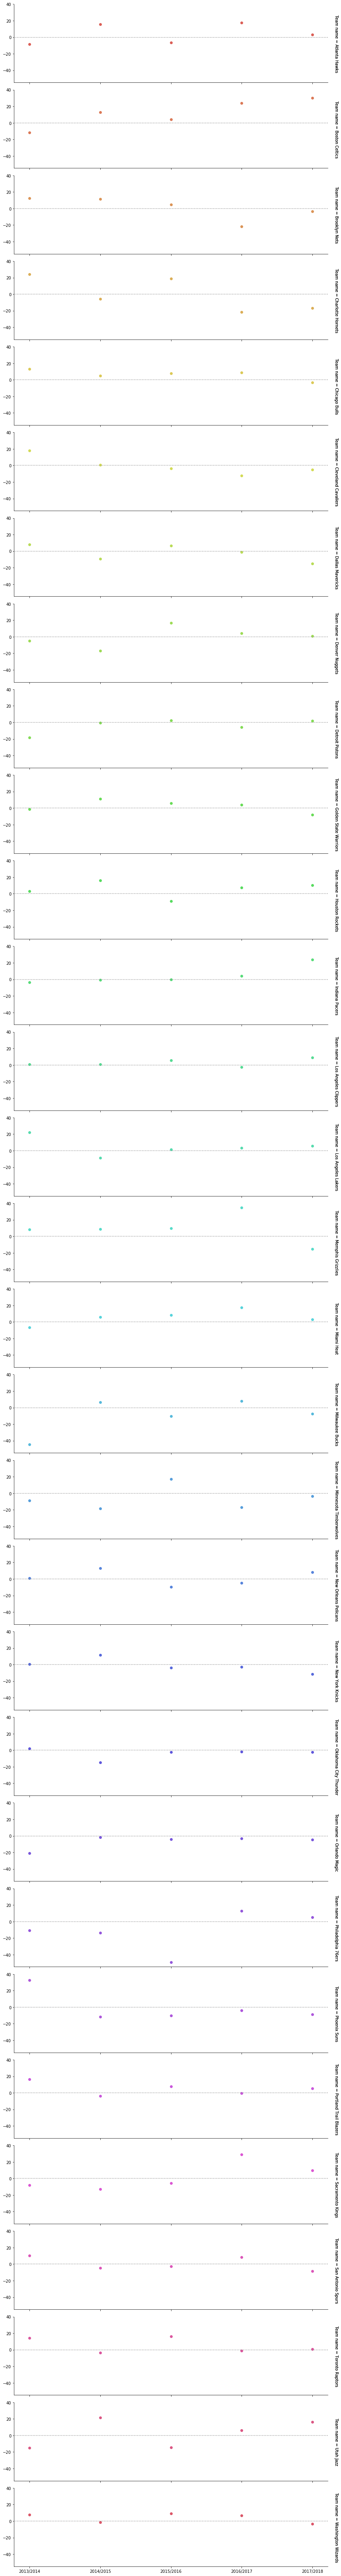

In [65]:
g = sns.FacetGrid(_df2[_df2.League=="NBA"], row="Team name", hue="Team name",
                  margin_titles=True, height=3, aspect=4, palette="hls")
g.map(plt.scatter, "Season", "Season returns");
# Draw a horizontal line to show 0 sum
g.map(plt.axhline, y=0, ls=":", c=".5");

In [66]:
# create DataFrames for each Euroleague team
df_bull = _df[_df["Team name"]=="Chicago Bulls"]
df_clip = _df[_df["Team name"]=="Los Angeles Clippers"]
df_orla = _df[_df["Team name"]=="Orlando Magic"]

In [67]:
# check when seasons ended
df_bull.groupby(["Season"])["Net outcome"].agg({'sum':'sum',
                                                'count':'count'}) 

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,sum,count
Season,,
2013/2014,13.12,95
2014/2015,4.71,101
2015/2016,7.68,90
2016/2017,8.62,95
2017/2018,-3.17,88


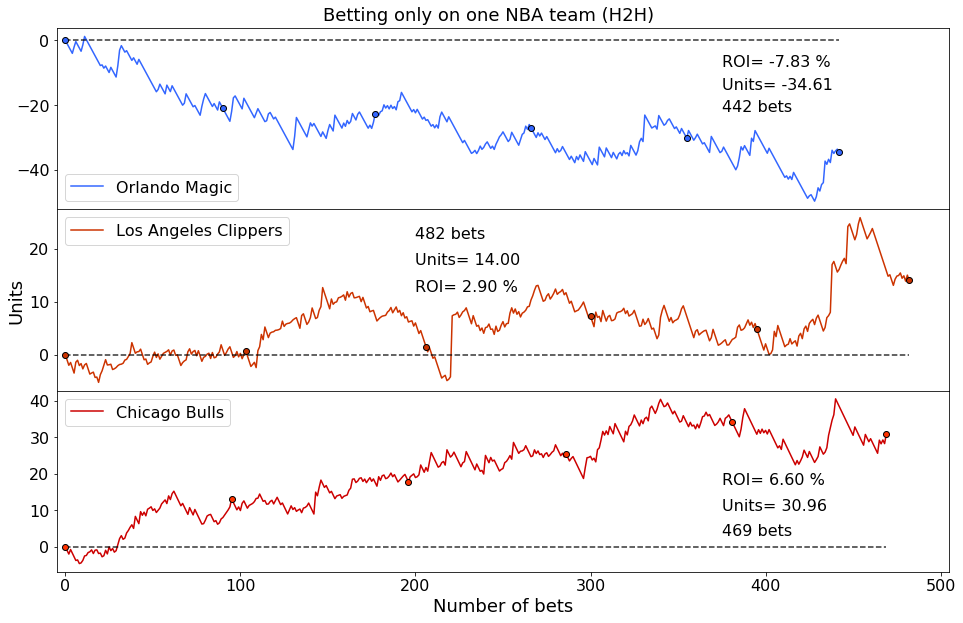

In [68]:
# plot results
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,10))
f.suptitle('Betting only on one NBA team (H2H)', y=0.91, fontsize=18)

# Orlando Magic
X1 = pd.Series(np.arange(0, df_orla.shape[0]+1)).values
# get cummunitative sum for bets
Y1 = df_orla["Net outcome"].cumsum().values
Y1 = np.append([0], Y1)
ax1.plot(X1, Y1, color="#3366ff", label="Orlando Magic")
ax1.plot([0, df_orla.shape[0]], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=16);
# manually show unit change over seasons
ax1.scatter([0, 90, 177, 266, 355, 442], [0, -21, -22.69, -27, -30.23, -34.61],
            color="#3366ff", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax1.text(375, -8, "ROI= {:.2f} %".format(df_orla["Net outcome"].mean()*100), fontsize=16)
ax1.text(375, -15, "Units= {:.2f}".format(df_orla["Net outcome"].sum()), fontsize=16)
ax1.text(375, -22, "{:.0f} bets".format(df_orla["Net outcome"].count()), fontsize=16)


# Los Angeles Clippers
X2 = pd.Series(np.arange(0, df_clip.shape[0]+1)).values
# get cummunitative sum for bets
Y2 = df_clip["Net outcome"].cumsum().values
Y2 = np.append([0], Y2)
ax2.plot(X2, Y2, color="#cc3300", label="Los Angeles Clippers")
ax2.plot([0, df_clip.shape[0]], [0, 0], "k--", alpha=0.8)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.set_ylim(-4.5, 4.5)
ax2.set_ylabel("Units", fontsize=18)
ax2.legend(fontsize=16);
# manually show unit change over seasons
ax2.scatter([0, 103, 206, 300, 395, 482], [0, 0.78, 1.54, 7.28, 4.87, 14],
            color="#cc3300", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax2.text(200, 12, "ROI= {:.2f} %".format(df_clip["Net outcome"].mean()*100), fontsize=16)
ax2.text(200, 17, "Units= {:.2f}".format(df_clip["Net outcome"].sum()), fontsize=16)
ax2.text(200, 22, "{:.0f} bets".format(df_clip["Net outcome"].count()), fontsize=16)

# Chicago Bulls
X3 = pd.Series(np.arange(0, df_bull.shape[0]+1)).values
# get cummunitative sum for bets
Y3 = df_bull["Net outcome"].cumsum().values
Y3 = np.append([0], Y3)
ax3.plot(X3, Y3, color="#cc0000", label="Chicago Bulls")
ax3.plot([0, df_bull.shape[0]], [0, 0], "k--", alpha=0.8)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.legend(fontsize=16);
ax3.set_xlabel("Number of bets", fontsize=18);
# ax3.set_ylim(-7.5, 37.5)
ax3.scatter([0, 95, 196, 286, 381, 469], [0, 13.12, 17.83, 25.51, 34.13, 30.96],
            color="#ff3300", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax3.text(375, 17, "ROI= {:.2f} %".format(df_bull["Net outcome"].mean()*100), fontsize=16)
ax3.text(375, 10, "Units= {:.2f}".format(df_bull["Net outcome"].sum()), fontsize=16)
ax3.text(375, 3, "{:.0f} bets".format(df_bull["Net outcome"].count()), fontsize=16)

ax3.set_xlim(-5, 505)

f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/nba_H2H_teams.png", dpi=200, format="png", bbox_inches="tight")

### 3.3.3 Asian handicap (AH) games
In theory AH should be more efficient than H2H. It is unlikely that you will find some profitable stategies.

In [69]:
%%time
# copy only head to head bets
_df = df_bets[df_bets["Bet type"]=="AH"].copy().reindex()

_results = list()
# iterate over unique match links
for url in _df.URL.unique():
    # take only H2H data for particular match
    _data = _df[_df.URL == url].reindex()
    # home team outcome
    _home = _data.iloc[0]
    _results.append([_home["Home_name"], _home["Bet subtype"], _home["URL"], _home["Net outcome"],
                    _home["League"], _home["Season"]])
    # away team outcome
    _away = _data.iloc[1]
    _results.append([_away["Away_name"], _away["Bet subtype"], _away["URL"], _away["Net outcome"],
                    _away["League"], _away["Season"]])
    
# save it to new DataFrame
_df = pd.DataFrame(_results, columns=["Team name", "Bet subtype", "URL", "Net outcome", "League", "Season"])

Wall time: 35.2 s


In [70]:
_df.head()

,Team name,Bet subtype,URL,Net outcome,League,Season
0,Barcelona,Home-2.5,https://www.oddsportal.com/basketball/europe/e...,0.98,EURO,2013/2014
1,CSKA Moscow,Away-2.5,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014
2,Barcelona,Home2.5,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014
3,Real Madrid,Away2.5,https://www.oddsportal.com/basketball/europe/e...,1.20,EURO,2013/2014
4,CSKA Moscow,Home-6.5,https://www.oddsportal.com/basketball/europe/e...,-1.00,EURO,2013/2014


In [71]:
_returns = _df.groupby(["League", "Team name", "Season"])["Net outcome"].sum()
_df2 = pd.DataFrame({"Season returns": _returns}).reset_index()
# get only team names which aprticipated in all 5 seasons
team_names = _df2["Team name"].value_counts()[_df2["Team name"].value_counts()==5].index
_df2 = _df2[_df2['Team name'].isin(team_names)]
_df2.head()

,League,Team name,Season,Season returns
1,EURO,Anadolu Efes,2013/2014,-7.19
2,EURO,Anadolu Efes,2014/2015,1.94
3,EURO,Anadolu Efes,2015/2016,1.92
4,EURO,Anadolu Efes,2016/2017,2.11
5,EURO,Anadolu Efes,2017/2018,-10.12


In [72]:
_group = _df2.groupby(["League", "Team name"])["Season returns"].agg({'sum':'sum', 
                                                                      'mean':'mean',
                                                                      'std':'std'}) 
_group.sort_values(['sum', 'mean', 'std'], ascending=[False, False, True])
# _group.sort_values(['std'], ascending=[True])

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


sum   mean        std
League Team name                                      
NBA    Toronto Raptors         39.41  7.882   6.740239
       San Antonio Spurs       38.48  7.696   2.741583
       Golden State Warriors   38.21  7.642  11.540818
       Boston Celtics          35.98  7.196  10.113443
       Portland Trail Blazers  24.42  4.884   5.854526
       Houston Rockets         23.66  4.732  10.386093
EURO   Crvena zvezda mts       21.44  4.288   4.584323
NBA    Indiana Pacers          19.41  3.882   9.881213
EURO   Zalgiris Kaunas         17.95  3.590   2.603190
       Baskonia                16.34  3.268   4.680723
       Fenerbahce              15.90  3.180   4.185379
       Olympiakos              15.10  3.020   3.654128
NBA    Miami Heat              14.57  2.914   9.880497
       Atlanta Hawks           12.26  2.452   9.594075
       Phoenix Suns             8.94  1.788  11.449975
       Washington Wizards       8.94  1.788   7.151742
       Utah Jazz                6.20  1.240   8.270904
       Dallas Mavericks         5.00  1.000   6.874460
EURO   Real Madrid              3.53  0.706   7.424600
NBA    Brooklyn Nets            2.83  0.566   8.128560
       Oklahoma City Thunder    2.48  0.496   8.131462
       New Orleans Pelicans     0.09  0.018   9.825951
       Chicago Bulls           -0.68 -0.136   5.523371
       Charlotte Hornets       -3.12 -0.624   6.628924
       Denver Nuggets          -3.39 -0.678   9.928556
EURO   Maccabi Tel Aviv        -5.78 -1.156   3.270219
NBA    Philadelphia 76ers      -8.26 -1.652  13.510423
EURO   Panathinaikos           -8.31 -1.662   1.540948
       Olimpia Milano         -11.08 -2.216   5.805061
       Anadolu Efes           -11.34 -2.268   5.922277
NBA    Los Angeles Clippers   -13.20 -2.640   6.080777
EURO   Barcelona              -14.84 -2.968   6.565278
NBA    Detroit Pistons        -15.10 -3.020   7.953144
EURO   CSKA Moscow            -16.82 -3.364   4.765153
NBA    Memphis Grizzlies      -26.35 -5.270   6.601985
       New York Knicks        -27.60 -5.520   9.161193
       Minnesota Timberwolves -29.01 -5.802   4.301229
       Sacramento Kings       -31.83 -6.366   7.478364
       Los Angeles Lakers     -34.79 -6.958   6.661994
       Orlando Magic          -35.70 -7.140  12.606627
       Cleveland Cavaliers    -36.94 -7.388   9.221181
       Milwaukee Bucks        -38.96 -7.792   9.240672

#### Euroleague team returns on AH bets

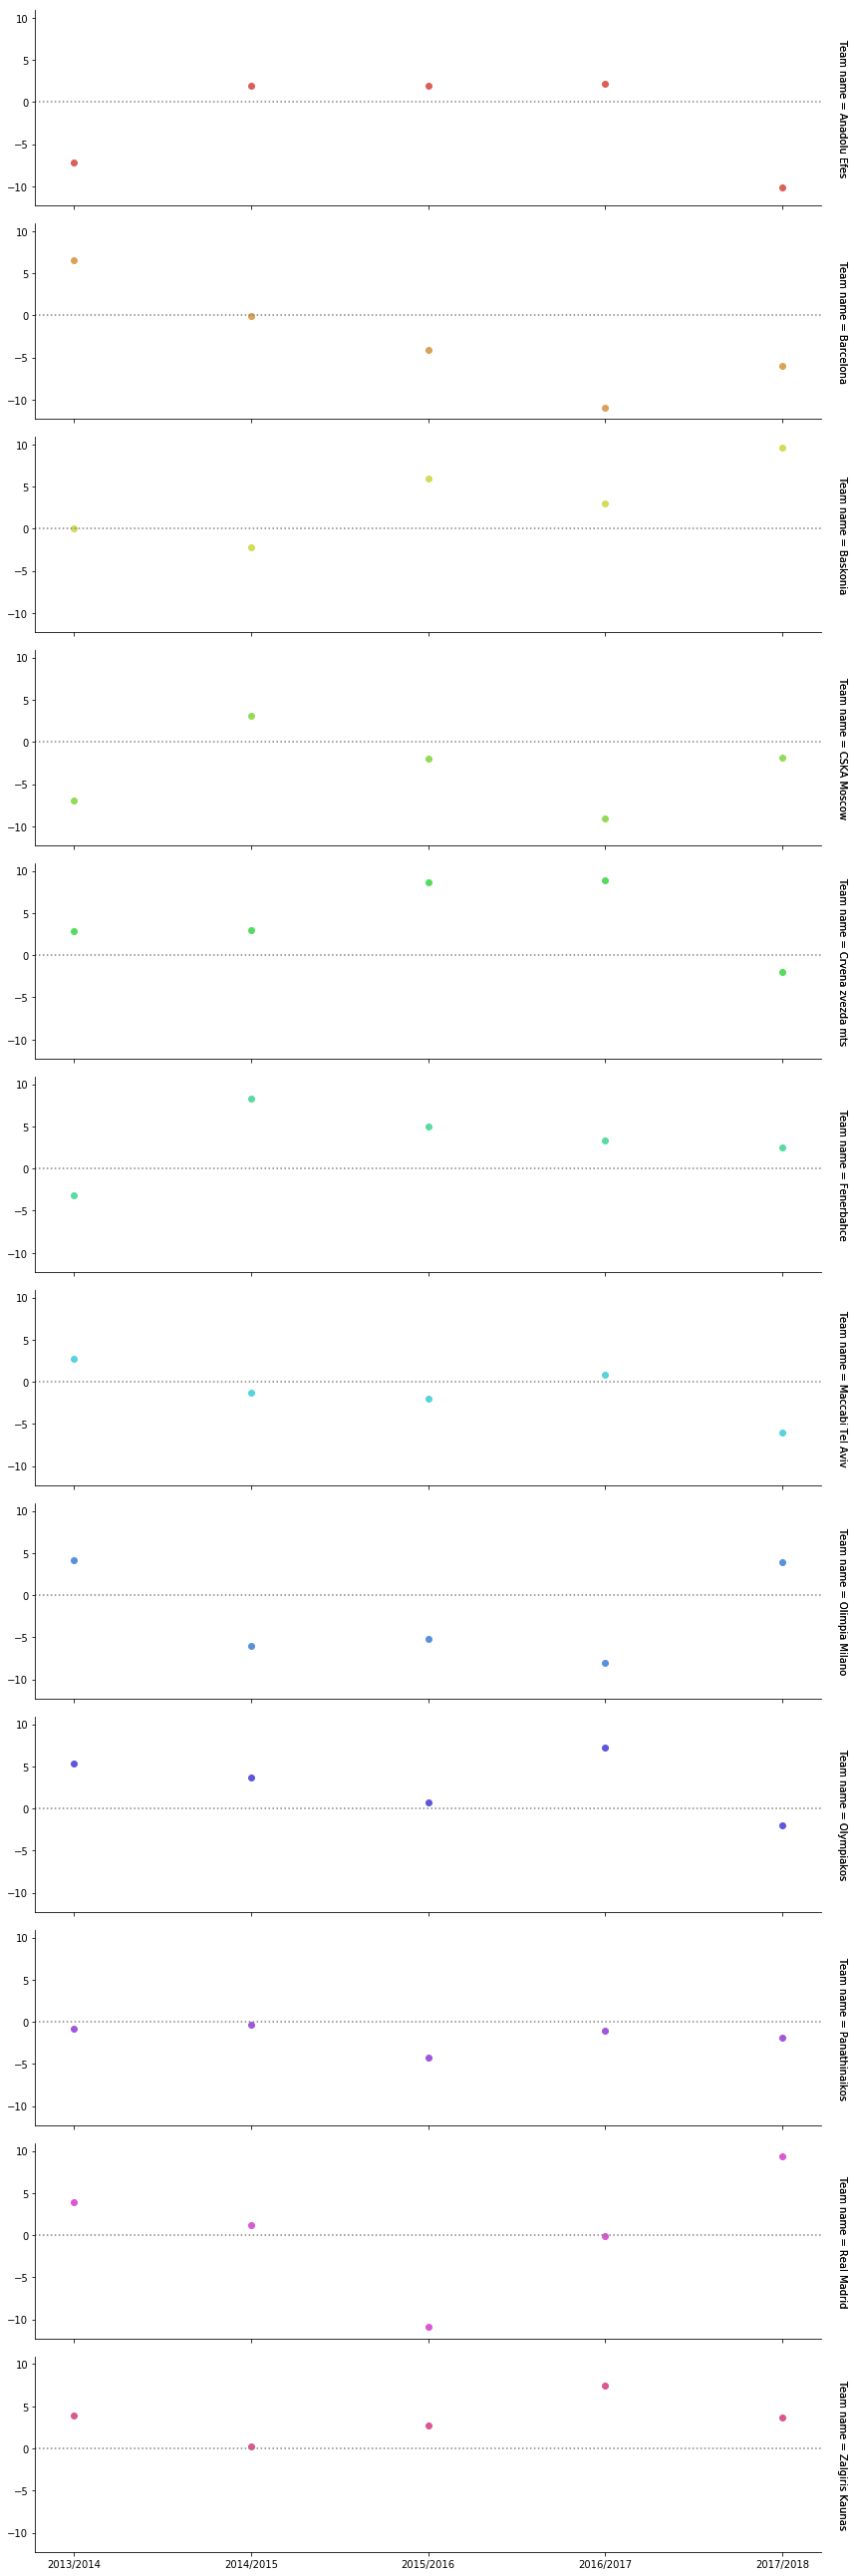

In [73]:
g = sns.FacetGrid(_df2[_df2.League=="EURO"], row="Team name", hue="Team name",
                  margin_titles=True, height=3, aspect=4, palette="hls")
g.map(plt.scatter, "Season", "Season returns");
# Draw a horizontal line to show 0 sum
g.map(plt.axhline, y=0, ls=":", c=".5");

In [74]:
# create DataFrames for each Euroleague team
df_pana = _df[_df["Team name"]=="Panathinaikos"]
df_zalg = _df[_df["Team name"]=="Zalgiris Kaunas"]
df_real = _df[_df["Team name"]=="Real Madrid"]

In [75]:
# check when seasons ended
df_zalg.groupby(["Season"])["Net outcome"].agg({'sum':'sum',
                                                'count':'count'}) 

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,sum,count
Season,,
2013/2014,3.95,24
2014/2015,0.19,24
2015/2016,2.69,24
2016/2017,7.41,30
2017/2018,3.71,32


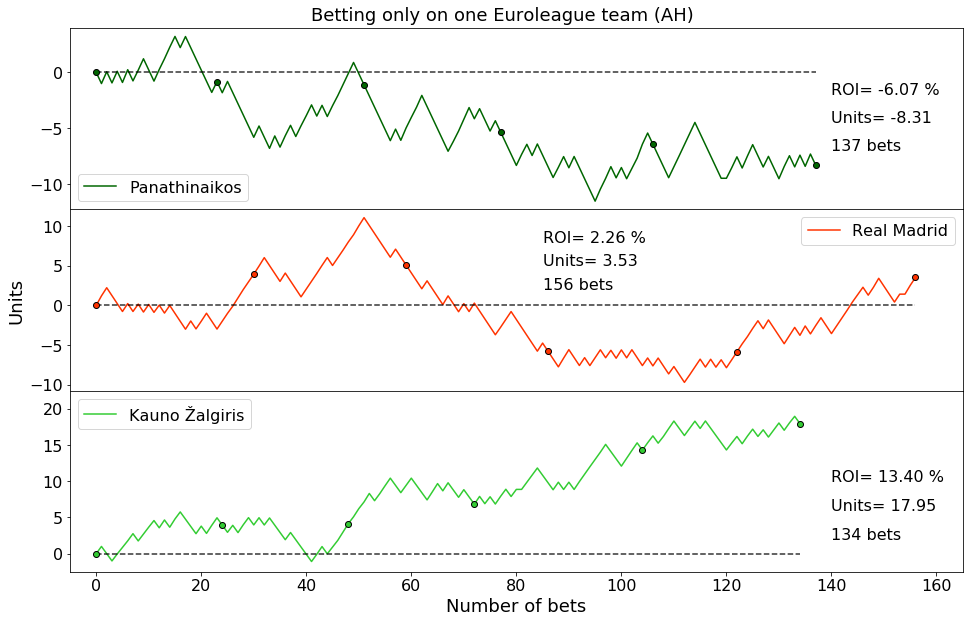

In [76]:
# plot results
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,10))
f.suptitle('Betting only on one Euroleague team (AH)', y=0.91, fontsize=18)

# Panathinaikos
X1 = pd.Series(np.arange(0, df_pana.shape[0]+1)).values
# get cummunitative sum for bets
Y1 = df_pana["Net outcome"].cumsum().values
Y1 = np.append([0], Y1)
ax1.plot(X1, Y1, color="#006600", label="Panathinaikos")
ax1.plot([0, df_pana.shape[0]], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=16, loc=3);
# manually show unit change over seasons
ax1.scatter([0, 23, 51, 77, 106, 137], [0, -0.82, -1.11, -5.33, -6.43, -8.31],
            color="#006600", edgecolors='k', zorder=10)
# calculate ROI, units and number of placed bets
ax1.text(140, -2, "ROI= {:.2f} %".format(df_pana["Net outcome"].mean()*100), fontsize=16)
ax1.text(140, -4.5, "Units= {:.2f}".format(df_pana["Net outcome"].sum()), fontsize=16)
ax1.text(140, -7, "{:.0f} bets".format(df_pana["Net outcome"].count()), fontsize=16)

# Real
X2 = pd.Series(np.arange(0, df_real.shape[0]+1)).values
# get cummunitative sum for bets
Y2 = df_real["Net outcome"].cumsum().values
Y2 = np.append([0], Y2)
ax2.plot(X2, Y2, color="#ff3300", label="Real Madrid")
ax2.plot([0, df_real.shape[0]], [0, 0], "k--", alpha=0.8)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.set_ylim(-4.5, 4.5)
ax2.set_ylabel("Units", fontsize=18)
ax2.legend(fontsize=16);
# # manually show unit change over seasons
ax2.scatter([0, 30, 59, 86, 122, 156], [0, 3.94, 5.10, -5.76, -5.86, 3.53],
            color="#ff3300", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax2.text(85, 8, "ROI= {:.2f} %".format(df_real["Net outcome"].mean()*100), fontsize=16)
ax2.text(85, 5, "Units= {:.2f}".format(df_real["Net outcome"].sum()), fontsize=16)
ax2.text(85, 2, "{:.0f} bets".format(df_real["Net outcome"].count()), fontsize=16)

# Zalgiris
X3 = pd.Series(np.arange(0, df_zalg.shape[0]+1)).values
# get cummunitative sum for bets
Y3 = df_zalg["Net outcome"].cumsum().values
Y3 = np.append([0], Y3)
ax3.plot(X3, Y3, color="#33cc33", label="Kauno Žalgiris")
ax3.plot([0, df_zalg.shape[0]], [0, 0], "k--", alpha=0.8)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.legend(fontsize=16, loc=2);
ax3.set_xlabel("Number of bets", fontsize=18);
ax3.set_ylim(-2.5, 22.5)
ax3.scatter([0, 24, 48, 72, 104, 134], [0, 3.95, 4.14, 6.83, 14.24, 17.95],
            color="#33cc33", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax3.text(140, 10, "ROI= {:.2f} %".format(df_zalg["Net outcome"].mean()*100), fontsize=16)
ax3.text(140, 6, "Units= {:.2f}".format(df_zalg["Net outcome"].sum()), fontsize=16)
ax3.text(140, 2, "{:.0f} bets".format(df_zalg["Net outcome"].count()), fontsize=16)

ax3.set_xlim(-5, 165)

f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/euroleague_AH_teams.png", dpi=200, format="png", bbox_inches="tight")

#### NBA team returns on AH bets

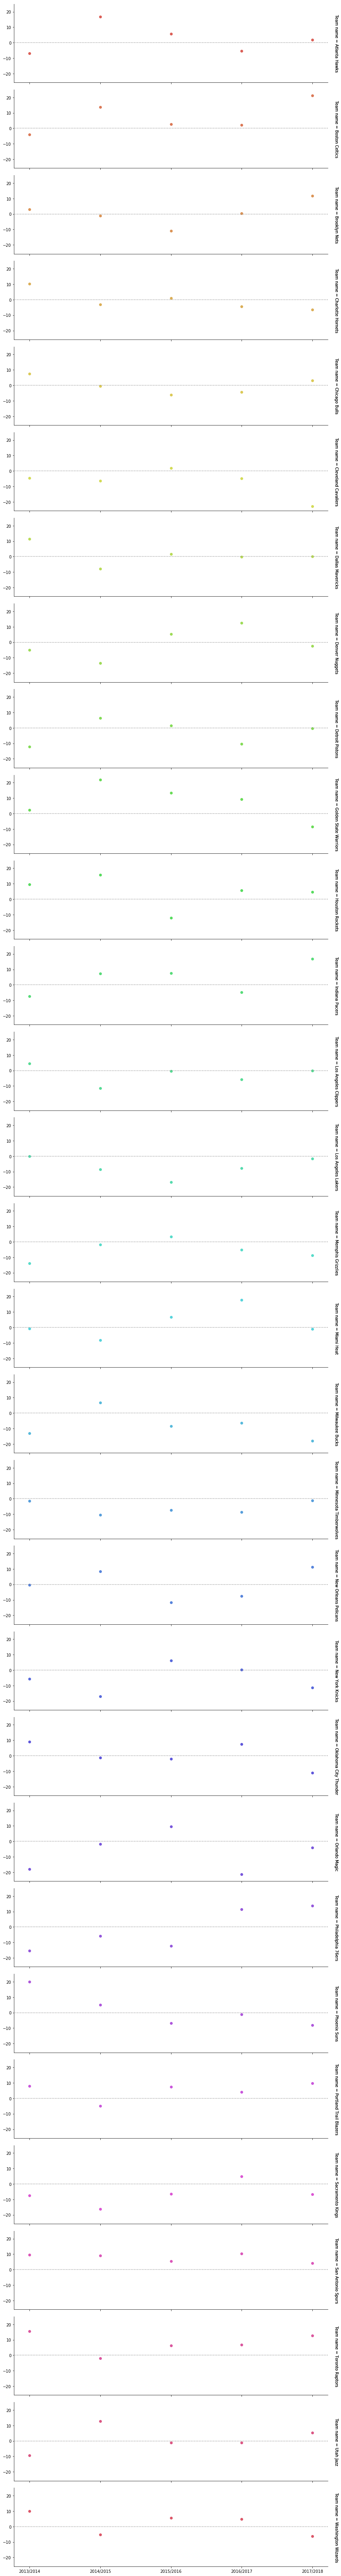

In [77]:
g = sns.FacetGrid(_df2[_df2.League=="NBA"], row="Team name", hue="Team name",
                  margin_titles=True, height=3, aspect=4, palette="hls")
g.map(plt.scatter, "Season", "Season returns");
# Draw a horizontal line to show 0 sum
g.map(plt.axhline, y=0, ls=":", c=".5");

In [78]:
# create DataFrames for each NBA team
df_spur = _df[_df["Team name"]=="San Antonio Spurs"]
df_timb = _df[_df["Team name"]=="Minnesota Timberwolves"]
df_peli = _df[_df["Team name"]=="New Orleans Pelicans"]

In [79]:
# check when seasons ended
df_spur.groupby(["Season"])["Net outcome"].agg({'sum':'sum',
                                                'count':'count'}) 

C:\Users\Tomas\PycharmProjects\Interesting_Sport_Stats\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


,sum,count
Season,,
2013/2014,9.52,107
2014/2015,9.10,83
2015/2016,5.48,98
2016/2017,10.30,97
2017/2018,4.08,88


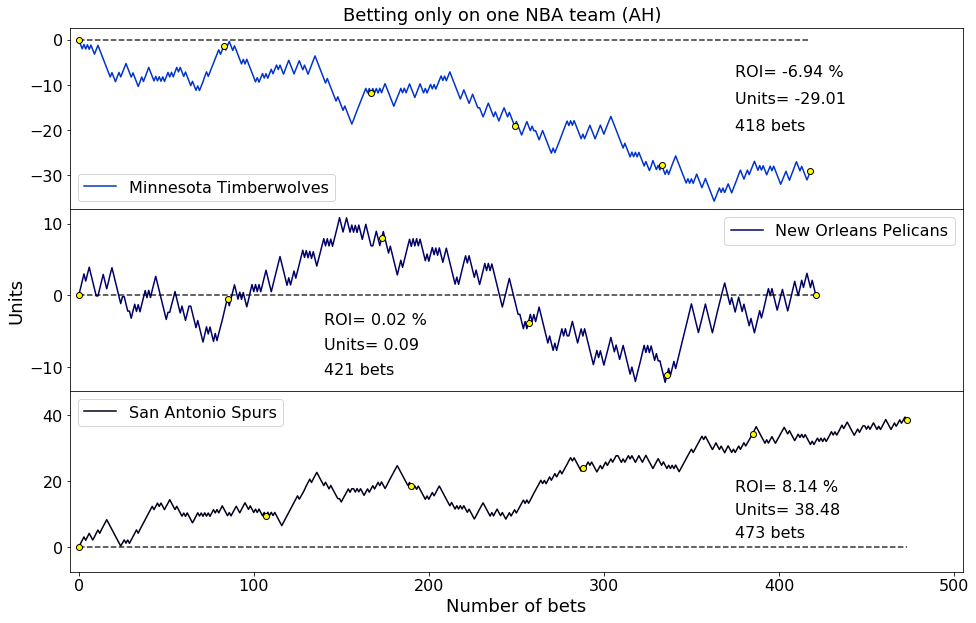

In [80]:
# plot results
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,10))
f.suptitle('Betting only on one NBA team (AH)', y=0.91, fontsize=18)

# Minnesota Timberwolves
X1 = pd.Series(np.arange(0, df_timb.shape[0]+1)).values
# get cummunitative sum for bets
Y1 = df_timb["Net outcome"].cumsum().values
Y1 = np.append([0], Y1)
ax1.plot(X1, Y1, color="#0033cc", label="Minnesota Timberwolves")
ax1.plot([0, df_timb.shape[0]], [0, 0], "k--", alpha=0.8)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=16);
# manually show unit change over seasons
ax1.scatter([0, 83, 167, 249, 333, 418], [0, -1.29, -11.79, -19.06, -27.78, -29.01],
            color="#ffff00", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax1.text(375, -8, "ROI= {:.2f} %".format(df_timb["Net outcome"].mean()*100), fontsize=16)
ax1.text(375, -14, "Units= {:.2f}".format(df_timb["Net outcome"].sum()), fontsize=16)
ax1.text(375, -20, "{:.0f} bets".format(df_timb["Net outcome"].count()), fontsize=16)


# New Orleans Pelicans
X2 = pd.Series(np.arange(0, df_peli.shape[0]+1)).values
# get cummunitative sum for bets
Y2 = df_peli["Net outcome"].cumsum().values
Y2 = np.append([0], Y2)
ax2.plot(X2, Y2, color="#000066", label="New Orleans Pelicans")
ax2.plot([0, df_peli.shape[0]], [0, 0], "k--", alpha=0.8)
ax2.tick_params(axis='both', which='major', labelsize=16)
# ax2.set_ylim(-4.5, 4.5)
ax2.set_ylabel("Units", fontsize=18)
ax2.legend(fontsize=16);
# manually show unit change over seasons
ax2.scatter([0, 85, 173, 257, 336, 421], [0, -0.45, 7.93, -3.86, -11.13, 0.09],
            color="#ffff00", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax2.text(140, -4, "ROI= {:.2f} %".format(df_peli["Net outcome"].mean()*100), fontsize=16)
ax2.text(140, -7.5, "Units= {:.2f}".format(df_peli["Net outcome"].sum()), fontsize=16)
ax2.text(140, -11, "{:.0f} bets".format(df_peli["Net outcome"].count()), fontsize=16)

# San Antonio Spurs
X3 = pd.Series(np.arange(0, df_spur.shape[0]+1)).values
# get cummunitative sum for bets
Y3 = df_spur["Net outcome"].cumsum().values
Y3 = np.append([0], Y3)
ax3.plot(X3, Y3, color="#00001a", label="San Antonio Spurs")
ax3.plot([0, df_spur.shape[0]], [0, 0], "k--", alpha=0.8)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.legend(fontsize=16);
ax3.set_xlabel("Number of bets", fontsize=18);
ax3.set_ylim(-7.5, 47.5)
ax3.scatter([0, 107, 190, 288, 385, 473], [0, 9.52, 18.62, 24.1, 34.4, 38.48],
            color="#ffff00", edgecolors='k', zorder=10)

# calculate ROI, units and number of placed bets
ax3.text(375, 17, "ROI= {:.2f} %".format(df_spur["Net outcome"].mean()*100), fontsize=16)
ax3.text(375, 10, "Units= {:.2f}".format(df_spur["Net outcome"].sum()), fontsize=16)
ax3.text(375, 3, "{:.0f} bets".format(df_spur["Net outcome"].count()), fontsize=16)

ax3.set_xlim(-5, 505)

f.subplots_adjust(hspace=0)
# Save figure
plt.savefig("images/nba_AH_teams.png", dpi=200, format="png", bbox_inches="tight")